In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 64
IMAGE_SIZE = 64
NZ = 100  # Size of latent vector
NC = 3   # Number of channels (RGB)
NGF = 64 # Generator feature map size
NDF = 64 # Discriminator feature map size
NUM_EPOCHS = 30
LR = 0.0002
BETA1 = 0.5

In [ ]:
class CelebADataset(Dataset):
    def __init__(self, img_dir, attr_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # Load attributes
        self.attr_df = pd.read_csv(attr_file)

        # Find Wavy_Hair column index
        self.wavy_hair_idx = None
        for i, col in enumerate(self.attr_df.columns):
            if 'Wavy_Hair' in col:
                self.wavy_hair_idx = i - 1  # -1 because first column is image name
                break

        if self.wavy_hair_idx is None:
            raise ValueError("Wavy_Hair attribute not found in the dataset")

        print(f"Wavy_Hair attribute found at index: {self.wavy_hair_idx}")

        # Get only images with wavy hair (value = 1)
        self.wavy_hair_images = self.attr_df[self.attr_df.iloc[:, self.wavy_hair_idx + 1] == 1]
        print(f"Found {len(self.wavy_hair_images)} images with wavy hair")

    def __len__(self):
        return len(self.wavy_hair_images)

    def __getitem__(self, idx):
        img_name = self.wavy_hair_images.iloc[idx, 0]  # First column is image name
        img_path = os.path.join(self.img_dir, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            # If image not found, return a black image
            image = Image.new('RGB', (178, 218), color='black')

        if self.transform:
            image = self.transform(image)

        # Return image and condition (1 for wavy hair)
        condition = torch.tensor([1.0], dtype=torch.float32)
        return image, condition

In [ ]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, nz, nc, ngf, condition_dim=1):
        super(Generator, self).__init__()
        self.condition_dim = condition_dim

        # Condition embedding
        self.condition_embed = nn.Sequential(
            nn.Linear(condition_dim, 50),
            nn.ReLU(True)
        )

        self.main = nn.Sequential(
            # Input: (nz + condition_embed_size) x 1 x 1
            nn.ConvTranspose2d(nz + 50, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # State: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # State: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # State: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # State: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: (nc) x 64 x 64
        )

    def forward(self, noise, condition):
        # Embed condition
        condition_embed = self.condition_embed(condition)
        condition_embed = condition_embed.view(condition_embed.size(0), -1, 1, 1)

        # Concatenate noise and condition
        input_tensor = torch.cat([noise, condition_embed], dim=1)

        return self.main(input_tensor)

In [ ]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, nc, ndf, condition_dim=1):
        super(Discriminator, self).__init__()
        self.condition_dim = condition_dim

        # Condition embedding
        self.condition_embed = nn.Sequential(
            nn.Linear(condition_dim, IMAGE_SIZE * IMAGE_SIZE),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.main = nn.Sequential(
            # Input: (nc + 1) x 64 x 64 (image + condition channel)
            nn.Conv2d(nc + 1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # State: (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # State: (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # State: (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # State: (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Output: 1 x 1 x 1
        )

    def forward(self, image, condition):
        # Embed condition and reshape to match image dimensions
        condition_embed = self.condition_embed(condition)
        condition_embed = condition_embed.view(condition_embed.size(0), 1, IMAGE_SIZE, IMAGE_SIZE)

        # Concatenate image and condition
        input_tensor = torch.cat([image, condition_embed], dim=1)

        output = self.main(input_tensor)
        return output.view(-1, 1).squeeze(1)


In [ ]:

# Weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create models
netG = Generator(NZ, NC, NGF).to(device)
netD = Discriminator(NC, NDF).to(device)

# Apply weight initialization
netG.apply(weights_init)
netD.apply(weights_init)

print("Generator:")
print(netG)
print("\nDiscriminator:")
print(netD)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(BETA1, 0.999))

# Create dataset and dataloader
# Update these paths to your actual dataset locations
IMG_DIR = "/content/img_align_celeba/img_align_celeba"  # Update this path
ATTR_FILE = "/content/list_attr_celeba.csv"  # Update this path

try:
    dataset = CelebADataset(IMG_DIR, ATTR_FILE, transform=transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    print(f"Dataset loaded successfully with {len(dataset)} images")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please update IMG_DIR and ATTR_FILE paths in the code")
    # Create dummy data for demonstration
    print("Creating dummy dataset for demonstration...")

    class DummyDataset(Dataset):
        def __init__(self, size=1000):
            self.size = size

        def __len__(self):
            return self.size

        def __getitem__(self, idx):
            # Generate random image
            image = torch.randn(3, IMAGE_SIZE, IMAGE_SIZE)
            condition = torch.tensor([1.0], dtype=torch.float32)
            return image, condition

    dataset = DummyDataset()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Fixed noise and condition for visualization
fixed_noise = torch.randn(10, NZ, 1, 1, device=device)
fixed_condition = torch.ones(10, 1, device=device)  # All wavy hair


Using device: cuda
Generator:
Generator(
  (condition_embed): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): ReLU(inplace=True)
  )
  (main): Sequential(
    (0): ConvTranspose2d(150, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

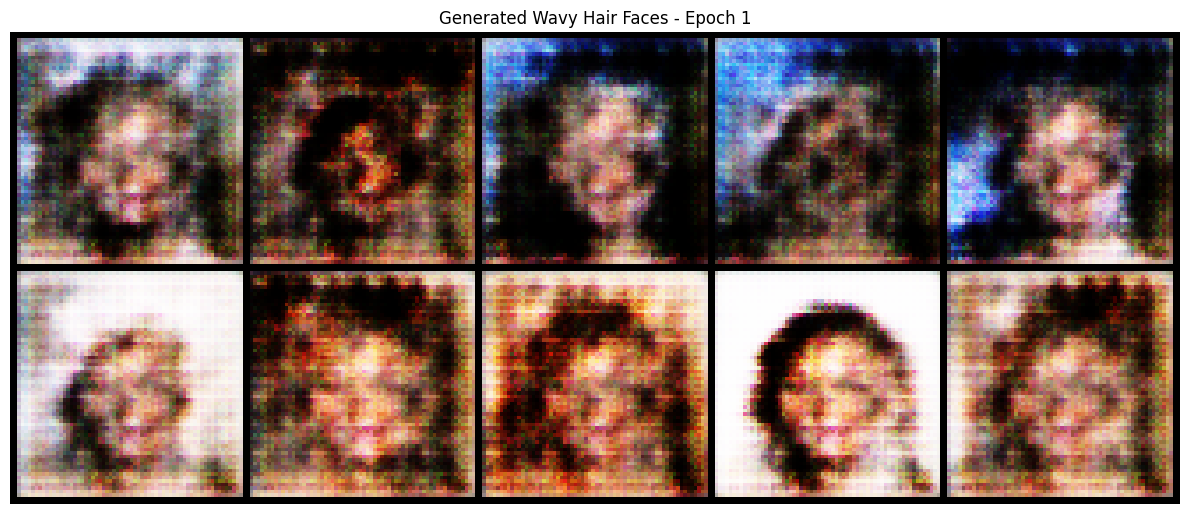

[1/30][0/1012] Loss_D: 0.9006 Loss_G: 3.6267 D(x): 0.7932 D(G(z)): 0.4063 / 0.0430
[1/30][50/1012] Loss_D: 1.0332 Loss_G: 5.0259 D(x): 0.4827 D(G(z)): 0.0228 / 0.0189
[1/30][100/1012] Loss_D: 0.6889 Loss_G: 2.8401 D(x): 0.7372 D(G(z)): 0.2593 / 0.1008
[1/30][150/1012] Loss_D: 1.1033 Loss_G: 7.5150 D(x): 0.8321 D(G(z)): 0.4935 / 0.0015
[1/30][200/1012] Loss_D: 0.8983 Loss_G: 2.4764 D(x): 0.6539 D(G(z)): 0.2347 / 0.1197
[1/30][250/1012] Loss_D: 0.7471 Loss_G: 2.4877 D(x): 0.6659 D(G(z)): 0.2046 / 0.1200
[1/30][300/1012] Loss_D: 0.7375 Loss_G: 2.8586 D(x): 0.6545 D(G(z)): 0.1838 / 0.0836
[1/30][350/1012] Loss_D: 0.8688 Loss_G: 3.3801 D(x): 0.6730 D(G(z)): 0.2301 / 0.0555
[1/30][400/1012] Loss_D: 0.9750 Loss_G: 2.2935 D(x): 0.5752 D(G(z)): 0.1493 / 0.1517
[1/30][450/1012] Loss_D: 0.8265 Loss_G: 3.0538 D(x): 0.6058 D(G(z)): 0.0727 / 0.1212
[1/30][500/1012] Loss_D: 0.9224 Loss_G: 4.6146 D(x): 0.9497 D(G(z)): 0.5188 / 0.0163
[1/30][550/1012] Loss_D: 1.1070 Loss_G: 6.3512 D(x): 0.8383 D(G(z)):

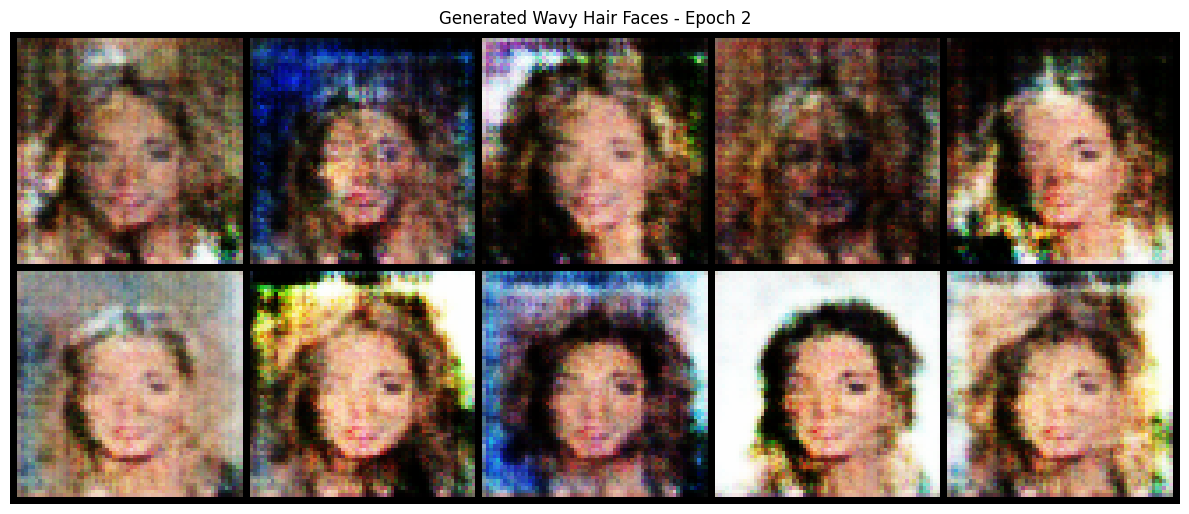

[2/30][0/1012] Loss_D: 0.8296 Loss_G: 3.8082 D(x): 0.7036 D(G(z)): 0.3057 / 0.0339
[2/30][50/1012] Loss_D: 0.7803 Loss_G: 2.3861 D(x): 0.5871 D(G(z)): 0.0918 / 0.1358
[2/30][100/1012] Loss_D: 0.5847 Loss_G: 4.0166 D(x): 0.6343 D(G(z)): 0.0364 / 0.0316
[2/30][150/1012] Loss_D: 1.5855 Loss_G: 1.4365 D(x): 0.3264 D(G(z)): 0.0554 / 0.3010
[2/30][200/1012] Loss_D: 0.8178 Loss_G: 5.1212 D(x): 0.8044 D(G(z)): 0.3967 / 0.0096
[2/30][250/1012] Loss_D: 1.2984 Loss_G: 5.7918 D(x): 0.8862 D(G(z)): 0.5933 / 0.0060
[2/30][300/1012] Loss_D: 0.4849 Loss_G: 3.4892 D(x): 0.7775 D(G(z)): 0.1537 / 0.0457
[2/30][350/1012] Loss_D: 0.7932 Loss_G: 1.6330 D(x): 0.6246 D(G(z)): 0.1923 / 0.2324
[2/30][400/1012] Loss_D: 0.8264 Loss_G: 5.0291 D(x): 0.7972 D(G(z)): 0.3792 / 0.0119
[2/30][450/1012] Loss_D: 0.4956 Loss_G: 3.1949 D(x): 0.7384 D(G(z)): 0.0971 / 0.0581
[2/30][500/1012] Loss_D: 0.4798 Loss_G: 3.6278 D(x): 0.8223 D(G(z)): 0.1981 / 0.0498
[2/30][550/1012] Loss_D: 0.5884 Loss_G: 3.6933 D(x): 0.8180 D(G(z)):

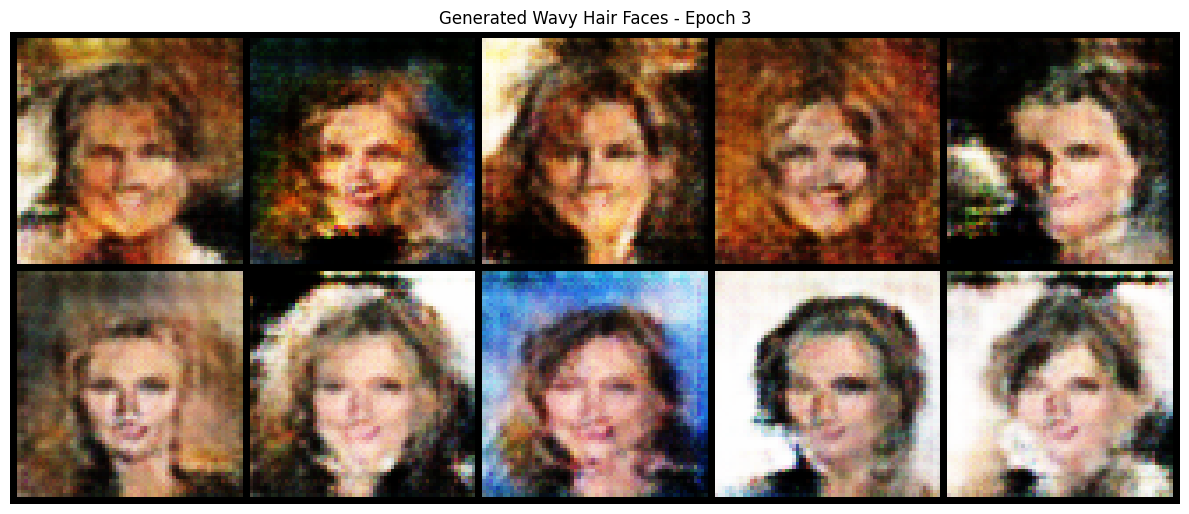

[3/30][0/1012] Loss_D: 0.6318 Loss_G: 3.2084 D(x): 0.8370 D(G(z)): 0.3179 / 0.0581
[3/30][50/1012] Loss_D: 1.1780 Loss_G: 6.4670 D(x): 0.9736 D(G(z)): 0.5902 / 0.0030
[3/30][100/1012] Loss_D: 0.6541 Loss_G: 2.8866 D(x): 0.6504 D(G(z)): 0.0876 / 0.1034
[3/30][150/1012] Loss_D: 1.0287 Loss_G: 2.5175 D(x): 0.4863 D(G(z)): 0.0265 / 0.1538
[3/30][200/1012] Loss_D: 0.4771 Loss_G: 3.6150 D(x): 0.6915 D(G(z)): 0.0350 / 0.0473
[3/30][250/1012] Loss_D: 0.2703 Loss_G: 4.3063 D(x): 0.8851 D(G(z)): 0.1173 / 0.0204
[3/30][300/1012] Loss_D: 0.5209 Loss_G: 3.0452 D(x): 0.7716 D(G(z)): 0.1627 / 0.0617
[3/30][350/1012] Loss_D: 0.5785 Loss_G: 5.6971 D(x): 0.8957 D(G(z)): 0.3087 / 0.0055
[3/30][400/1012] Loss_D: 1.0445 Loss_G: 5.7641 D(x): 0.9817 D(G(z)): 0.5520 / 0.0069
[3/30][450/1012] Loss_D: 0.6385 Loss_G: 3.5699 D(x): 0.7733 D(G(z)): 0.2457 / 0.0472
[3/30][500/1012] Loss_D: 0.6561 Loss_G: 4.4466 D(x): 0.8728 D(G(z)): 0.3386 / 0.0214
[3/30][550/1012] Loss_D: 0.6527 Loss_G: 3.0272 D(x): 0.7679 D(G(z)):

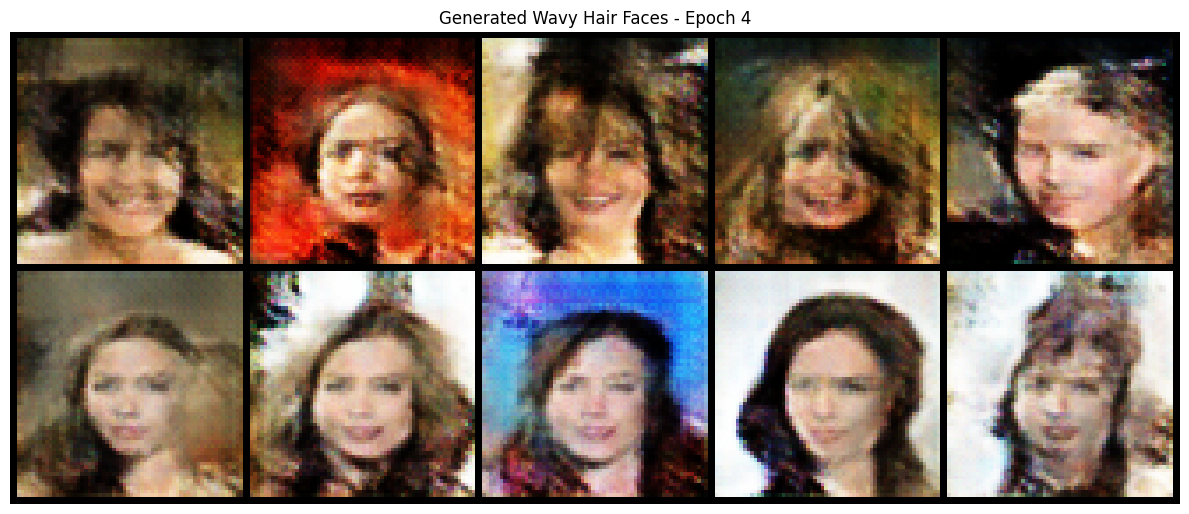

[4/30][0/1012] Loss_D: 0.6184 Loss_G: 3.5933 D(x): 0.7179 D(G(z)): 0.1997 / 0.0421
[4/30][50/1012] Loss_D: 0.7361 Loss_G: 1.7683 D(x): 0.6641 D(G(z)): 0.1844 / 0.2233
[4/30][100/1012] Loss_D: 0.6175 Loss_G: 2.8115 D(x): 0.6159 D(G(z)): 0.0223 / 0.1015
[4/30][150/1012] Loss_D: 0.5097 Loss_G: 2.7457 D(x): 0.7523 D(G(z)): 0.1581 / 0.0989
[4/30][200/1012] Loss_D: 1.1448 Loss_G: 4.1514 D(x): 0.8310 D(G(z)): 0.5325 / 0.0267
[4/30][250/1012] Loss_D: 0.7995 Loss_G: 1.9069 D(x): 0.5729 D(G(z)): 0.1023 / 0.1951
[4/30][300/1012] Loss_D: 0.9158 Loss_G: 1.6423 D(x): 0.5190 D(G(z)): 0.0625 / 0.2509
[4/30][350/1012] Loss_D: 1.2009 Loss_G: 1.0770 D(x): 0.4165 D(G(z)): 0.0643 / 0.4185
[4/30][400/1012] Loss_D: 0.6076 Loss_G: 3.4975 D(x): 0.8203 D(G(z)): 0.2816 / 0.0396
[4/30][450/1012] Loss_D: 0.8499 Loss_G: 1.5593 D(x): 0.5469 D(G(z)): 0.0814 / 0.2904
[4/30][500/1012] Loss_D: 0.8222 Loss_G: 3.5359 D(x): 0.7960 D(G(z)): 0.3605 / 0.0435
[4/30][550/1012] Loss_D: 0.4478 Loss_G: 3.2426 D(x): 0.7796 D(G(z)):

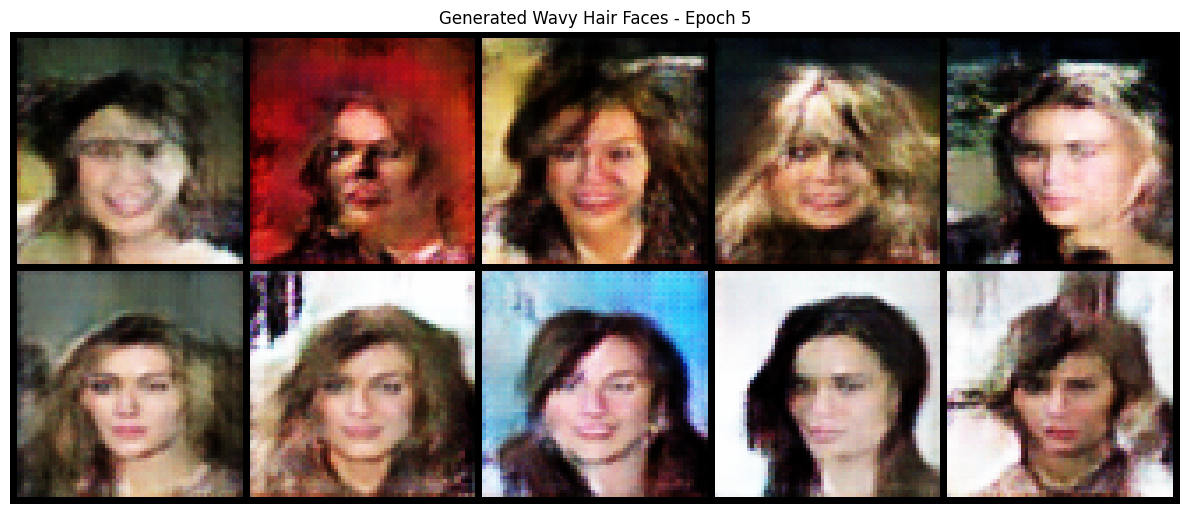

[5/30][0/1012] Loss_D: 0.5757 Loss_G: 3.6819 D(x): 0.8188 D(G(z)): 0.2273 / 0.0441
[5/30][50/1012] Loss_D: 0.6075 Loss_G: 2.4569 D(x): 0.7477 D(G(z)): 0.2262 / 0.1115
[5/30][100/1012] Loss_D: 0.6118 Loss_G: 2.8907 D(x): 0.7439 D(G(z)): 0.2238 / 0.0778
[5/30][150/1012] Loss_D: 0.8975 Loss_G: 1.8126 D(x): 0.5001 D(G(z)): 0.0546 / 0.2154
[5/30][200/1012] Loss_D: 1.1561 Loss_G: 2.2472 D(x): 0.5825 D(G(z)): 0.3603 / 0.1523
[5/30][250/1012] Loss_D: 0.6991 Loss_G: 3.2755 D(x): 0.8112 D(G(z)): 0.3298 / 0.0524
[5/30][300/1012] Loss_D: 0.6630 Loss_G: 3.7839 D(x): 0.8624 D(G(z)): 0.3555 / 0.0338
[5/30][350/1012] Loss_D: 1.0358 Loss_G: 1.8575 D(x): 0.4751 D(G(z)): 0.0564 / 0.2125
[5/30][400/1012] Loss_D: 0.6854 Loss_G: 3.5342 D(x): 0.8770 D(G(z)): 0.3691 / 0.0408
[5/30][450/1012] Loss_D: 0.6574 Loss_G: 1.7553 D(x): 0.6175 D(G(z)): 0.0742 / 0.2148
[5/30][500/1012] Loss_D: 0.6679 Loss_G: 1.6120 D(x): 0.6640 D(G(z)): 0.1753 / 0.2452
[5/30][550/1012] Loss_D: 0.6296 Loss_G: 3.9175 D(x): 0.8124 D(G(z)):

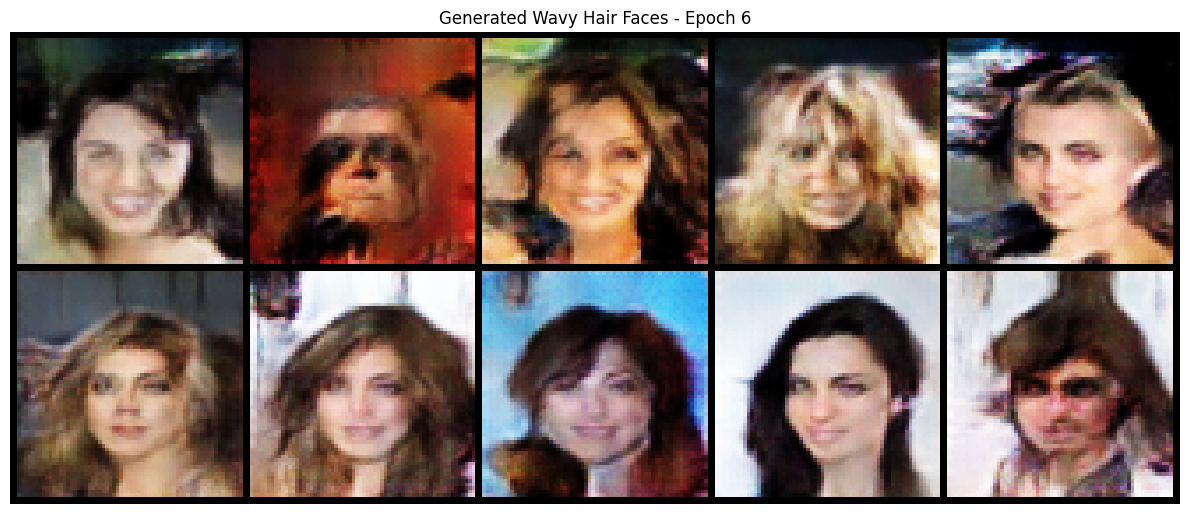

[6/30][0/1012] Loss_D: 1.0306 Loss_G: 4.0283 D(x): 0.8419 D(G(z)): 0.5067 / 0.0260
[6/30][50/1012] Loss_D: 0.8078 Loss_G: 1.5315 D(x): 0.5669 D(G(z)): 0.1073 / 0.2899
[6/30][100/1012] Loss_D: 0.7702 Loss_G: 4.0728 D(x): 0.9353 D(G(z)): 0.4567 / 0.0259
[6/30][150/1012] Loss_D: 0.9548 Loss_G: 1.8781 D(x): 0.5084 D(G(z)): 0.1170 / 0.2268
[6/30][200/1012] Loss_D: 0.7553 Loss_G: 2.0765 D(x): 0.6748 D(G(z)): 0.2299 / 0.1570
[6/30][250/1012] Loss_D: 1.1887 Loss_G: 4.7856 D(x): 0.8064 D(G(z)): 0.5412 / 0.0138
[6/30][300/1012] Loss_D: 0.7332 Loss_G: 1.6215 D(x): 0.6058 D(G(z)): 0.1452 / 0.2668
[6/30][350/1012] Loss_D: 0.5900 Loss_G: 2.0877 D(x): 0.6239 D(G(z)): 0.0568 / 0.1605
[6/30][400/1012] Loss_D: 0.8356 Loss_G: 1.5757 D(x): 0.5280 D(G(z)): 0.0726 / 0.2727
[6/30][450/1012] Loss_D: 0.6551 Loss_G: 2.7143 D(x): 0.6407 D(G(z)): 0.1022 / 0.1052
[6/30][500/1012] Loss_D: 0.9627 Loss_G: 1.1927 D(x): 0.5494 D(G(z)): 0.1851 / 0.3578
[6/30][550/1012] Loss_D: 1.0389 Loss_G: 3.9261 D(x): 0.9212 D(G(z)):

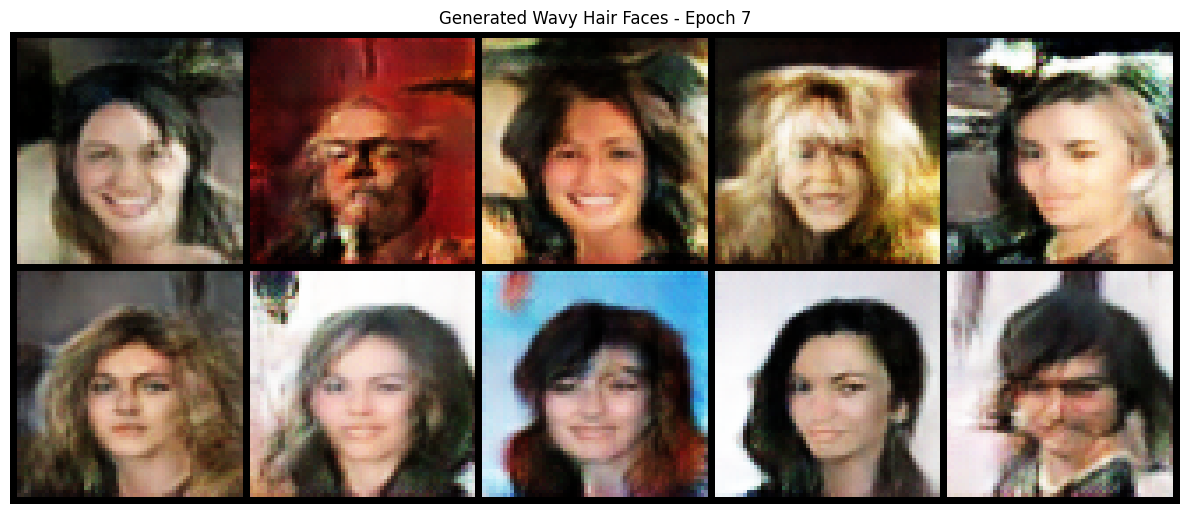

[7/30][0/1012] Loss_D: 0.8734 Loss_G: 1.6094 D(x): 0.5380 D(G(z)): 0.1213 / 0.2549
[7/30][50/1012] Loss_D: 0.4949 Loss_G: 2.7872 D(x): 0.7646 D(G(z)): 0.1535 / 0.0843
[7/30][100/1012] Loss_D: 0.9185 Loss_G: 1.4920 D(x): 0.5421 D(G(z)): 0.1327 / 0.2850
[7/30][150/1012] Loss_D: 0.5593 Loss_G: 3.5608 D(x): 0.8488 D(G(z)): 0.2861 / 0.0410
[7/30][200/1012] Loss_D: 0.7389 Loss_G: 1.3425 D(x): 0.5649 D(G(z)): 0.0937 / 0.3064
[7/30][250/1012] Loss_D: 0.7916 Loss_G: 1.3769 D(x): 0.5403 D(G(z)): 0.0715 / 0.3008
[7/30][300/1012] Loss_D: 0.8958 Loss_G: 1.5031 D(x): 0.5802 D(G(z)): 0.1862 / 0.2771
[7/30][350/1012] Loss_D: 0.5534 Loss_G: 2.6143 D(x): 0.7020 D(G(z)): 0.1209 / 0.1036
[7/30][400/1012] Loss_D: 1.3018 Loss_G: 2.1770 D(x): 0.3641 D(G(z)): 0.0230 / 0.1904
[7/30][450/1012] Loss_D: 0.7407 Loss_G: 3.0379 D(x): 0.7939 D(G(z)): 0.3367 / 0.0632
[7/30][500/1012] Loss_D: 0.5917 Loss_G: 2.4608 D(x): 0.6260 D(G(z)): 0.0398 / 0.1375
[7/30][550/1012] Loss_D: 0.5797 Loss_G: 3.9853 D(x): 0.9079 D(G(z)):

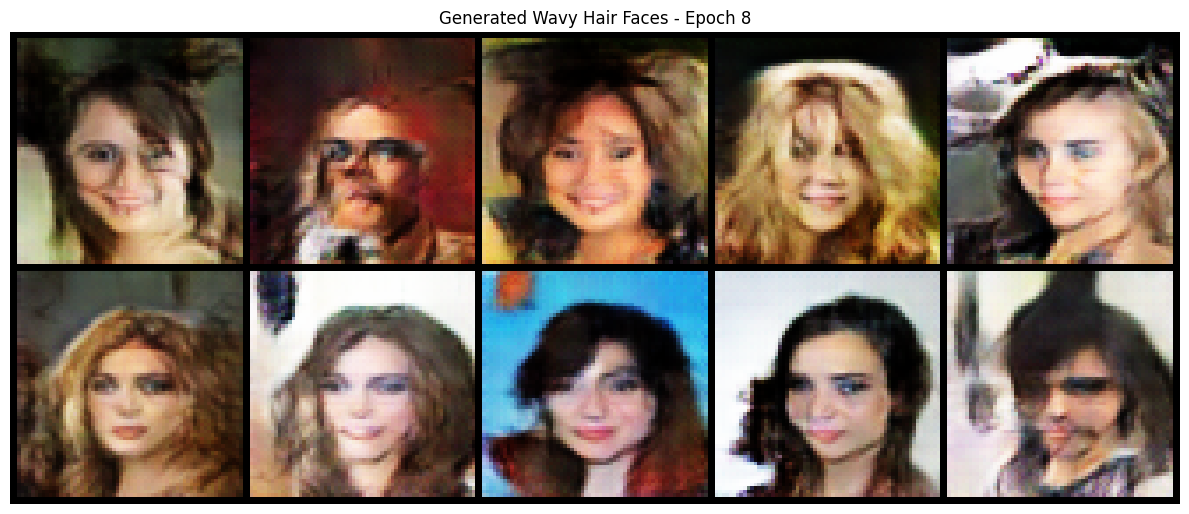

[8/30][0/1012] Loss_D: 0.5537 Loss_G: 2.8789 D(x): 0.8359 D(G(z)): 0.2674 / 0.0749
[8/30][50/1012] Loss_D: 0.4581 Loss_G: 2.2638 D(x): 0.7956 D(G(z)): 0.1747 / 0.1260
[8/30][100/1012] Loss_D: 1.1382 Loss_G: 2.1606 D(x): 0.5830 D(G(z)): 0.3628 / 0.1417
[8/30][150/1012] Loss_D: 0.5195 Loss_G: 1.8326 D(x): 0.8445 D(G(z)): 0.2587 / 0.1933
[8/30][200/1012] Loss_D: 0.6080 Loss_G: 1.9019 D(x): 0.6749 D(G(z)): 0.1373 / 0.1703
[8/30][250/1012] Loss_D: 0.5644 Loss_G: 2.8420 D(x): 0.7253 D(G(z)): 0.1564 / 0.0852
[8/30][300/1012] Loss_D: 0.6715 Loss_G: 3.3641 D(x): 0.9104 D(G(z)): 0.3857 / 0.0498
[8/30][350/1012] Loss_D: 0.4553 Loss_G: 2.7334 D(x): 0.8366 D(G(z)): 0.2161 / 0.0822
[8/30][400/1012] Loss_D: 0.9439 Loss_G: 1.4608 D(x): 0.6161 D(G(z)): 0.2766 / 0.2706
[8/30][450/1012] Loss_D: 0.7432 Loss_G: 1.1485 D(x): 0.6085 D(G(z)): 0.1361 / 0.3633
[8/30][500/1012] Loss_D: 0.8426 Loss_G: 3.9923 D(x): 0.8981 D(G(z)): 0.4686 / 0.0286
[8/30][550/1012] Loss_D: 0.5927 Loss_G: 2.3118 D(x): 0.7825 D(G(z)):

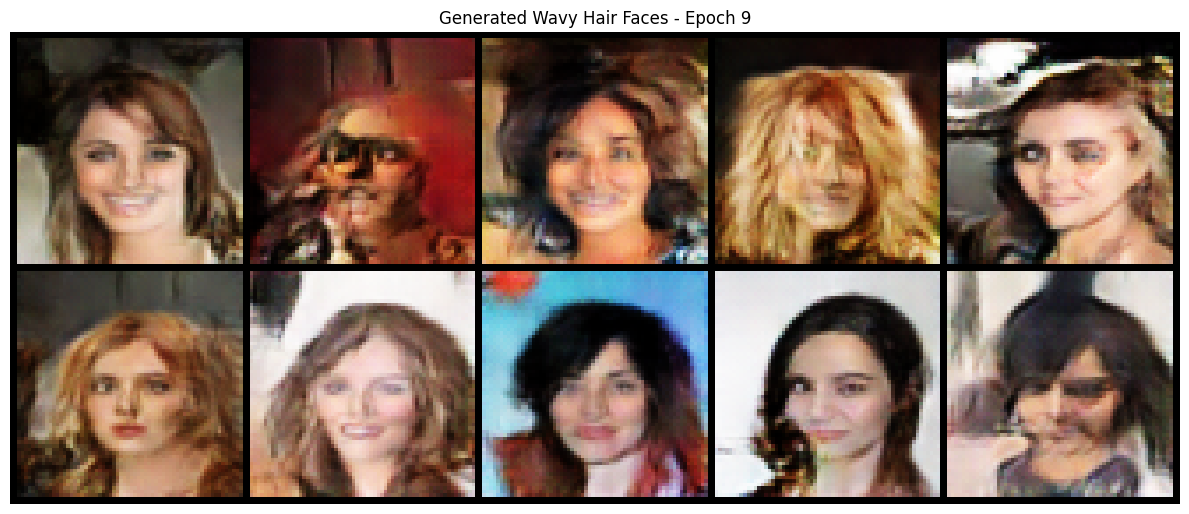

[9/30][0/1012] Loss_D: 0.8234 Loss_G: 1.4355 D(x): 0.5855 D(G(z)): 0.1499 / 0.2970
[9/30][50/1012] Loss_D: 0.5210 Loss_G: 2.6762 D(x): 0.8489 D(G(z)): 0.2679 / 0.0908
[9/30][100/1012] Loss_D: 0.7115 Loss_G: 3.1326 D(x): 0.7816 D(G(z)): 0.3220 / 0.0577
[9/30][150/1012] Loss_D: 0.6358 Loss_G: 1.8966 D(x): 0.6667 D(G(z)): 0.1402 / 0.2030
[9/30][200/1012] Loss_D: 0.6788 Loss_G: 2.0652 D(x): 0.6011 D(G(z)): 0.0785 / 0.1748
[9/30][250/1012] Loss_D: 1.3054 Loss_G: 5.8698 D(x): 0.9723 D(G(z)): 0.6589 / 0.0058
[9/30][300/1012] Loss_D: 0.6534 Loss_G: 1.7219 D(x): 0.6427 D(G(z)): 0.1375 / 0.2140
[9/30][350/1012] Loss_D: 0.6666 Loss_G: 1.4287 D(x): 0.6385 D(G(z)): 0.1235 / 0.3022
[9/30][400/1012] Loss_D: 0.5910 Loss_G: 2.5719 D(x): 0.6422 D(G(z)): 0.0577 / 0.1220
[9/30][450/1012] Loss_D: 0.7891 Loss_G: 0.9759 D(x): 0.6115 D(G(z)): 0.1829 / 0.4345
[9/30][500/1012] Loss_D: 0.5220 Loss_G: 2.4405 D(x): 0.7394 D(G(z)): 0.1569 / 0.1187
[9/30][550/1012] Loss_D: 0.4826 Loss_G: 2.1535 D(x): 0.7516 D(G(z)):

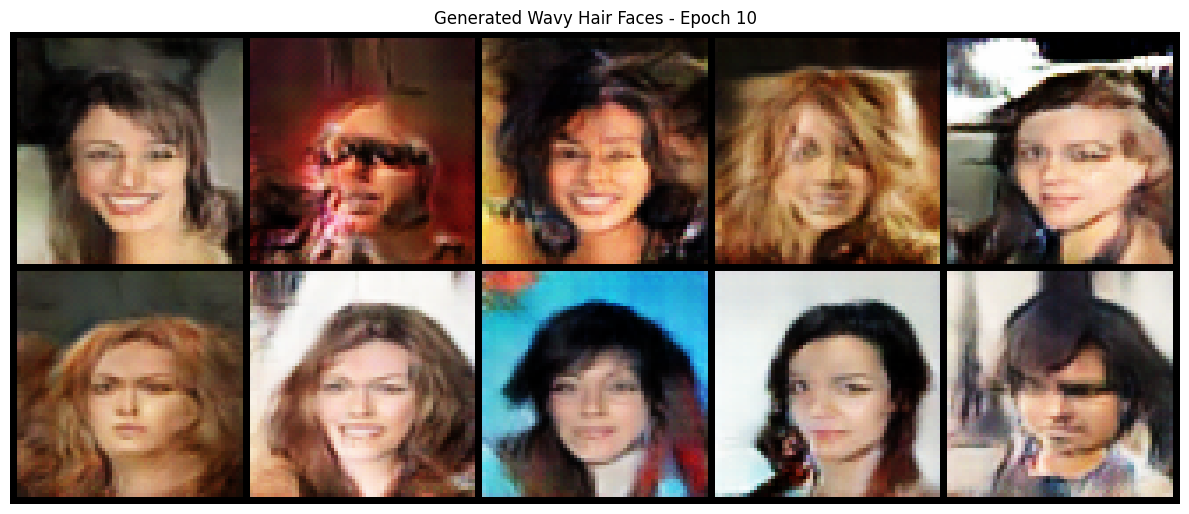

[10/30][0/1012] Loss_D: 0.5540 Loss_G: 3.3547 D(x): 0.8970 D(G(z)): 0.3113 / 0.0459
[10/30][50/1012] Loss_D: 0.5525 Loss_G: 2.2943 D(x): 0.7122 D(G(z)): 0.1466 / 0.1448
[10/30][100/1012] Loss_D: 0.5720 Loss_G: 4.0073 D(x): 0.9260 D(G(z)): 0.3382 / 0.0274
[10/30][150/1012] Loss_D: 0.7561 Loss_G: 1.2936 D(x): 0.6539 D(G(z)): 0.2035 / 0.3315
[10/30][200/1012] Loss_D: 0.4943 Loss_G: 2.8128 D(x): 0.8074 D(G(z)): 0.2112 / 0.0841
[10/30][250/1012] Loss_D: 0.4392 Loss_G: 3.8099 D(x): 0.8795 D(G(z)): 0.2426 / 0.0311
[10/30][300/1012] Loss_D: 0.5300 Loss_G: 2.8339 D(x): 0.8080 D(G(z)): 0.2174 / 0.0756
[10/30][350/1012] Loss_D: 0.8654 Loss_G: 1.2093 D(x): 0.5444 D(G(z)): 0.1109 / 0.3574
[10/30][400/1012] Loss_D: 0.5232 Loss_G: 4.0293 D(x): 0.9214 D(G(z)): 0.3254 / 0.0251
[10/30][450/1012] Loss_D: 0.6983 Loss_G: 4.3884 D(x): 0.8988 D(G(z)): 0.4000 / 0.0161
[10/30][500/1012] Loss_D: 0.5461 Loss_G: 2.3496 D(x): 0.7080 D(G(z)): 0.1229 / 0.1271
[10/30][550/1012] Loss_D: 0.6536 Loss_G: 3.8808 D(x): 0.9

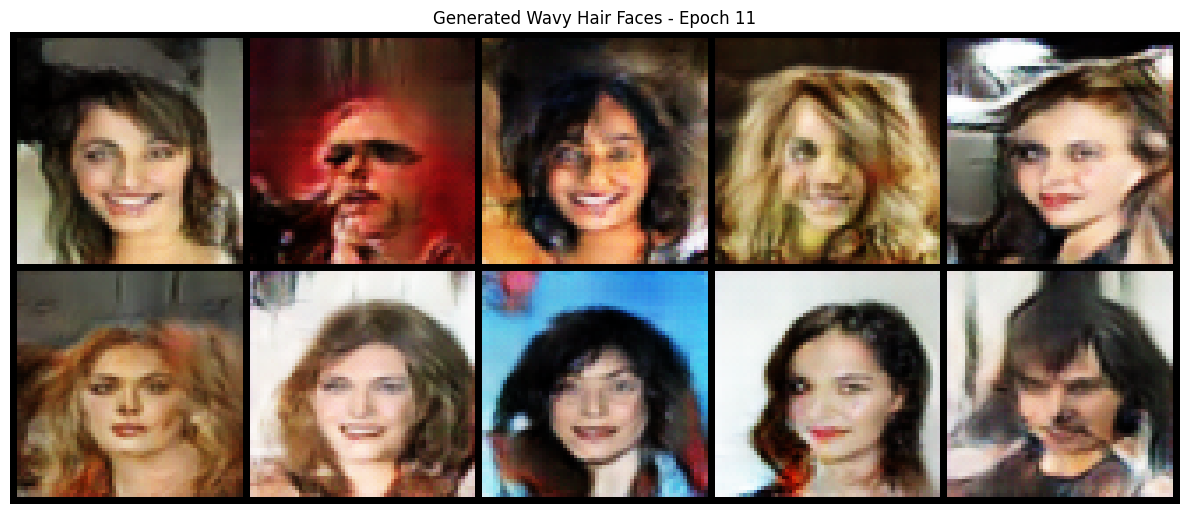

[11/30][0/1012] Loss_D: 0.4459 Loss_G: 3.0300 D(x): 0.7589 D(G(z)): 0.1157 / 0.0725
[11/30][50/1012] Loss_D: 0.6285 Loss_G: 1.5329 D(x): 0.6312 D(G(z)): 0.1018 / 0.2658
[11/30][100/1012] Loss_D: 0.8234 Loss_G: 5.4677 D(x): 0.9226 D(G(z)): 0.4645 / 0.0093
[11/30][150/1012] Loss_D: 0.8424 Loss_G: 1.6356 D(x): 0.5169 D(G(z)): 0.0534 / 0.2589
[11/30][200/1012] Loss_D: 0.3195 Loss_G: 3.0936 D(x): 0.8241 D(G(z)): 0.0987 / 0.0606
[11/30][250/1012] Loss_D: 0.4382 Loss_G: 2.3169 D(x): 0.8422 D(G(z)): 0.2021 / 0.1246
[11/30][300/1012] Loss_D: 0.4479 Loss_G: 2.8586 D(x): 0.7597 D(G(z)): 0.1082 / 0.0759
[11/30][350/1012] Loss_D: 0.4461 Loss_G: 3.2452 D(x): 0.8791 D(G(z)): 0.2387 / 0.0532
[11/30][400/1012] Loss_D: 0.3484 Loss_G: 3.9391 D(x): 0.9151 D(G(z)): 0.2094 / 0.0286
[11/30][450/1012] Loss_D: 0.6793 Loss_G: 4.2407 D(x): 0.9361 D(G(z)): 0.3999 / 0.0212
[11/30][500/1012] Loss_D: 0.7934 Loss_G: 3.1876 D(x): 0.7180 D(G(z)): 0.2714 / 0.0610
[11/30][550/1012] Loss_D: 0.5380 Loss_G: 1.8439 D(x): 0.6

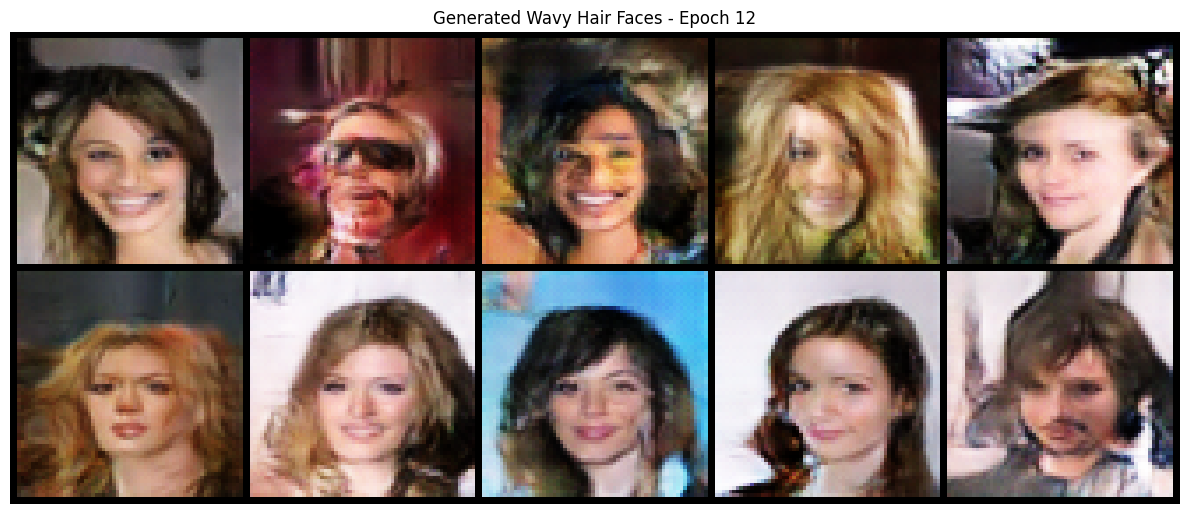

[12/30][0/1012] Loss_D: 0.7748 Loss_G: 5.6055 D(x): 0.9471 D(G(z)): 0.4561 / 0.0050
[12/30][50/1012] Loss_D: 0.6981 Loss_G: 1.0564 D(x): 0.5977 D(G(z)): 0.0986 / 0.3957
[12/30][100/1012] Loss_D: 0.7942 Loss_G: 2.0213 D(x): 0.5369 D(G(z)): 0.0328 / 0.1912
[12/30][150/1012] Loss_D: 0.6048 Loss_G: 2.5349 D(x): 0.6605 D(G(z)): 0.1044 / 0.1163
[12/30][200/1012] Loss_D: 0.4901 Loss_G: 1.6710 D(x): 0.7422 D(G(z)): 0.1288 / 0.2389
[12/30][250/1012] Loss_D: 0.6360 Loss_G: 3.0306 D(x): 0.7982 D(G(z)): 0.2683 / 0.0656
[12/30][300/1012] Loss_D: 0.5179 Loss_G: 1.9291 D(x): 0.7337 D(G(z)): 0.1294 / 0.1964
[12/30][350/1012] Loss_D: 0.3773 Loss_G: 3.0305 D(x): 0.7841 D(G(z)): 0.0917 / 0.0721
[12/30][400/1012] Loss_D: 1.0414 Loss_G: 0.9283 D(x): 0.4685 D(G(z)): 0.0637 / 0.4549
[12/30][450/1012] Loss_D: 0.3790 Loss_G: 2.5867 D(x): 0.8291 D(G(z)): 0.1460 / 0.0961
[12/30][500/1012] Loss_D: 0.6695 Loss_G: 4.1116 D(x): 0.9565 D(G(z)): 0.3669 / 0.0218
[12/30][550/1012] Loss_D: 0.4915 Loss_G: 2.3760 D(x): 0.7

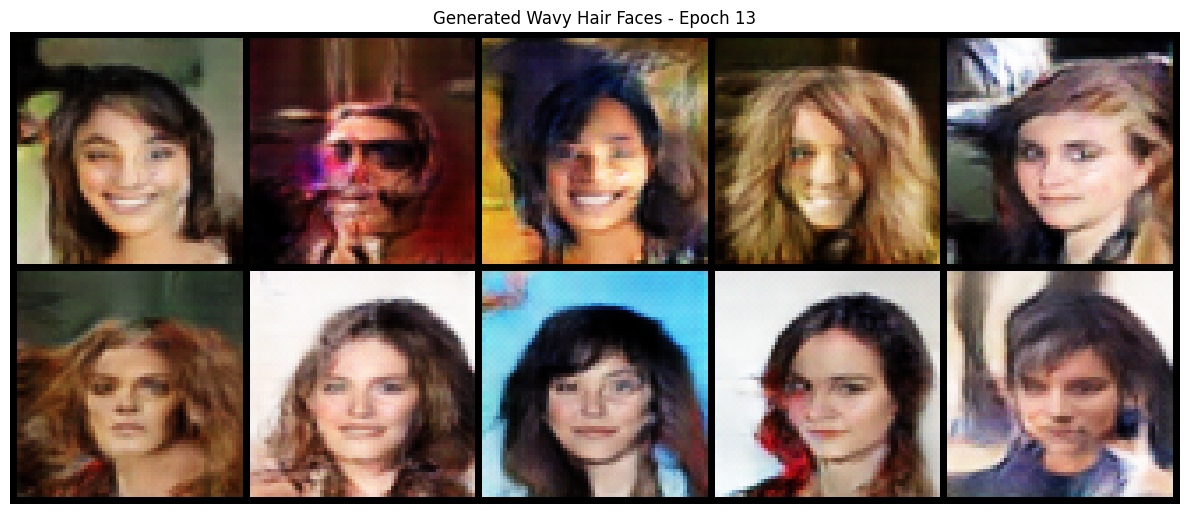

[13/30][0/1012] Loss_D: 1.3282 Loss_G: 0.8535 D(x): 0.3555 D(G(z)): 0.0348 / 0.5056
[13/30][50/1012] Loss_D: 0.4672 Loss_G: 2.2739 D(x): 0.7511 D(G(z)): 0.1190 / 0.1329
[13/30][100/1012] Loss_D: 0.9300 Loss_G: 1.4529 D(x): 0.4819 D(G(z)): 0.0289 / 0.3094
[13/30][150/1012] Loss_D: 2.0832 Loss_G: 6.8376 D(x): 0.9709 D(G(z)): 0.7423 / 0.0041
[13/30][200/1012] Loss_D: 0.3175 Loss_G: 3.6045 D(x): 0.8470 D(G(z)): 0.1236 / 0.0391
[13/30][250/1012] Loss_D: 0.2517 Loss_G: 2.9455 D(x): 0.8941 D(G(z)): 0.1186 / 0.0683
[13/30][300/1012] Loss_D: 1.0476 Loss_G: 0.8214 D(x): 0.4392 D(G(z)): 0.0464 / 0.4941
[13/30][350/1012] Loss_D: 0.4719 Loss_G: 3.7068 D(x): 0.8606 D(G(z)): 0.2342 / 0.0362
[13/30][400/1012] Loss_D: 0.4526 Loss_G: 2.9733 D(x): 0.8021 D(G(z)): 0.1677 / 0.0659
[13/30][450/1012] Loss_D: 0.3996 Loss_G: 2.6301 D(x): 0.7806 D(G(z)): 0.1061 / 0.1060
[13/30][500/1012] Loss_D: 0.4946 Loss_G: 3.1281 D(x): 0.7921 D(G(z)): 0.1904 / 0.0583
[13/30][550/1012] Loss_D: 1.0316 Loss_G: 5.8165 D(x): 0.9

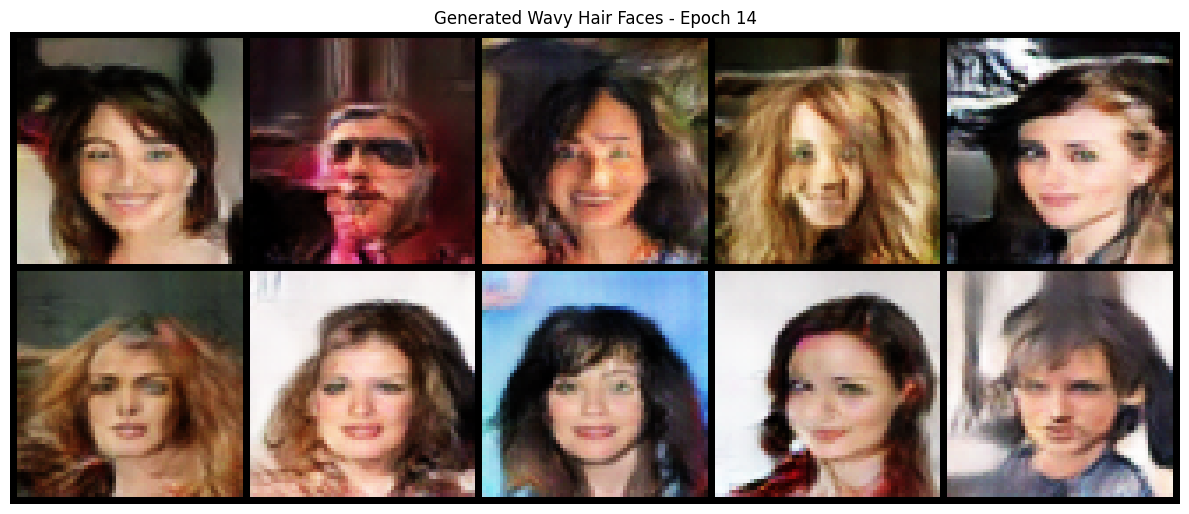

[14/30][0/1012] Loss_D: 0.3785 Loss_G: 3.5293 D(x): 0.9466 D(G(z)): 0.2439 / 0.0429
[14/30][50/1012] Loss_D: 0.4024 Loss_G: 3.1365 D(x): 0.8802 D(G(z)): 0.2059 / 0.0596
[14/30][100/1012] Loss_D: 0.5983 Loss_G: 2.0356 D(x): 0.6792 D(G(z)): 0.1270 / 0.1856
[14/30][150/1012] Loss_D: 0.4136 Loss_G: 2.2936 D(x): 0.7361 D(G(z)): 0.0732 / 0.1359
[14/30][200/1012] Loss_D: 0.3046 Loss_G: 3.5145 D(x): 0.9155 D(G(z)): 0.1704 / 0.0419
[14/30][250/1012] Loss_D: 0.5009 Loss_G: 2.2922 D(x): 0.7641 D(G(z)): 0.1543 / 0.1320
[14/30][300/1012] Loss_D: 0.4345 Loss_G: 3.3892 D(x): 0.8303 D(G(z)): 0.1905 / 0.0461
[14/30][350/1012] Loss_D: 1.6938 Loss_G: 7.0858 D(x): 0.9746 D(G(z)): 0.7307 / 0.0028
[14/30][400/1012] Loss_D: 0.7817 Loss_G: 4.5298 D(x): 0.9660 D(G(z)): 0.4441 / 0.0201
[14/30][450/1012] Loss_D: 0.3776 Loss_G: 2.8262 D(x): 0.8694 D(G(z)): 0.1842 / 0.0780
[14/30][500/1012] Loss_D: 0.4787 Loss_G: 1.8117 D(x): 0.6784 D(G(z)): 0.0364 / 0.2073
[14/30][550/1012] Loss_D: 0.6311 Loss_G: 1.9447 D(x): 0.6

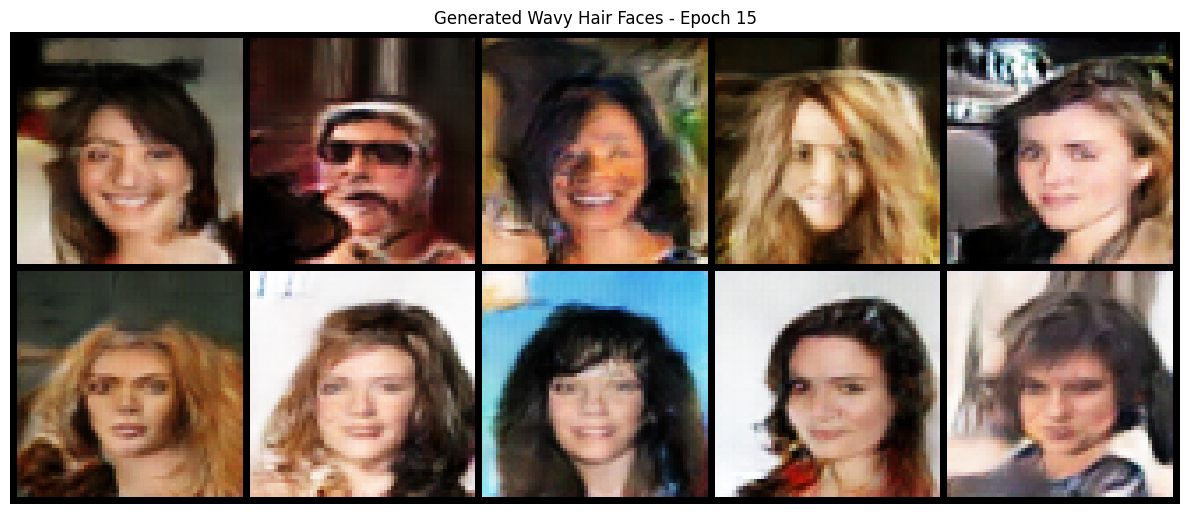

[15/30][0/1012] Loss_D: 1.0658 Loss_G: 0.2262 D(x): 0.4510 D(G(z)): 0.0222 / 0.8249
[15/30][50/1012] Loss_D: 0.5392 Loss_G: 2.8058 D(x): 0.6770 D(G(z)): 0.0448 / 0.0969
[15/30][100/1012] Loss_D: 1.1620 Loss_G: 5.5392 D(x): 0.9850 D(G(z)): 0.6068 / 0.0072
[15/30][150/1012] Loss_D: 0.2782 Loss_G: 3.8664 D(x): 0.8100 D(G(z)): 0.0423 / 0.0335
[15/30][200/1012] Loss_D: 0.5080 Loss_G: 3.6300 D(x): 0.8891 D(G(z)): 0.2742 / 0.0361
[15/30][250/1012] Loss_D: 0.3992 Loss_G: 1.8643 D(x): 0.7629 D(G(z)): 0.0790 / 0.1990
[15/30][300/1012] Loss_D: 0.5252 Loss_G: 3.9211 D(x): 0.8890 D(G(z)): 0.2926 / 0.0271
[15/30][350/1012] Loss_D: 0.3010 Loss_G: 3.8116 D(x): 0.9245 D(G(z)): 0.1703 / 0.0302
[15/30][400/1012] Loss_D: 0.6404 Loss_G: 3.0467 D(x): 0.8265 D(G(z)): 0.3224 / 0.0587
[15/30][450/1012] Loss_D: 0.4734 Loss_G: 4.4793 D(x): 0.8900 D(G(z)): 0.2551 / 0.0158
[15/30][500/1012] Loss_D: 0.6941 Loss_G: 2.4982 D(x): 0.5996 D(G(z)): 0.0668 / 0.1327
[15/30][550/1012] Loss_D: 0.4819 Loss_G: 4.6604 D(x): 0.9

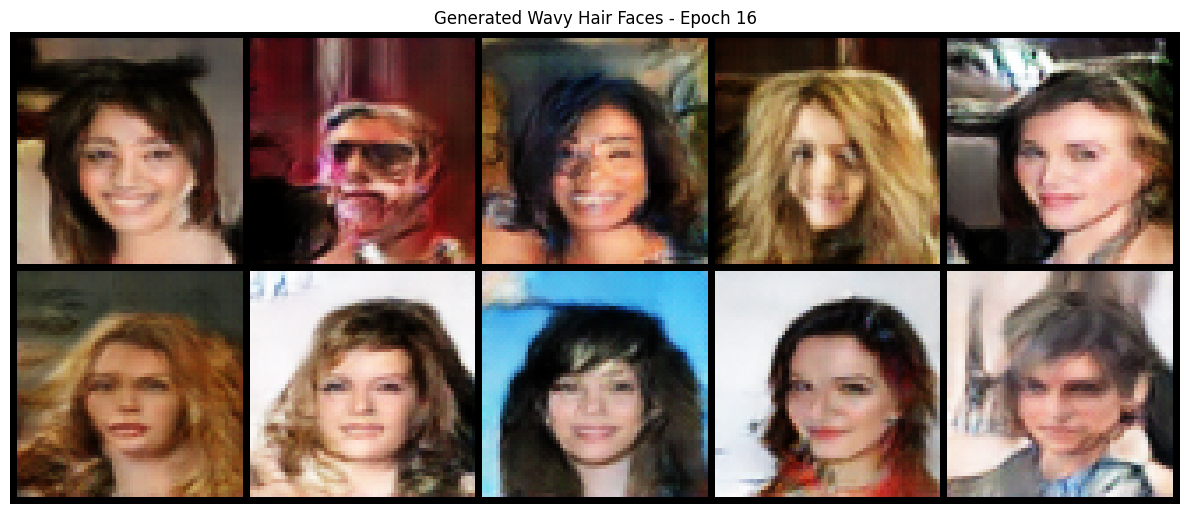

[16/30][0/1012] Loss_D: 0.5144 Loss_G: 1.7943 D(x): 0.7127 D(G(z)): 0.1007 / 0.2297
[16/30][50/1012] Loss_D: 0.3860 Loss_G: 2.1647 D(x): 0.7721 D(G(z)): 0.0866 / 0.1471
[16/30][100/1012] Loss_D: 0.4085 Loss_G: 1.9007 D(x): 0.7362 D(G(z)): 0.0550 / 0.2071
[16/30][150/1012] Loss_D: 0.6707 Loss_G: 4.1135 D(x): 0.8391 D(G(z)): 0.3227 / 0.0290
[16/30][200/1012] Loss_D: 0.4388 Loss_G: 2.1377 D(x): 0.7041 D(G(z)): 0.0339 / 0.1704
[16/30][250/1012] Loss_D: 0.3135 Loss_G: 3.6107 D(x): 0.9480 D(G(z)): 0.2016 / 0.0355
[16/30][300/1012] Loss_D: 0.3896 Loss_G: 3.5857 D(x): 0.9057 D(G(z)): 0.2245 / 0.0400
[16/30][350/1012] Loss_D: 0.3236 Loss_G: 3.2057 D(x): 0.8409 D(G(z)): 0.0997 / 0.0615
[16/30][400/1012] Loss_D: 0.2937 Loss_G: 4.7578 D(x): 0.9717 D(G(z)): 0.2130 / 0.0121
[16/30][450/1012] Loss_D: 0.2696 Loss_G: 3.0325 D(x): 0.8686 D(G(z)): 0.1054 / 0.0674
[16/30][500/1012] Loss_D: 0.5562 Loss_G: 5.3440 D(x): 0.8968 D(G(z)): 0.3105 / 0.0070
[16/30][550/1012] Loss_D: 0.6577 Loss_G: 1.0077 D(x): 0.6

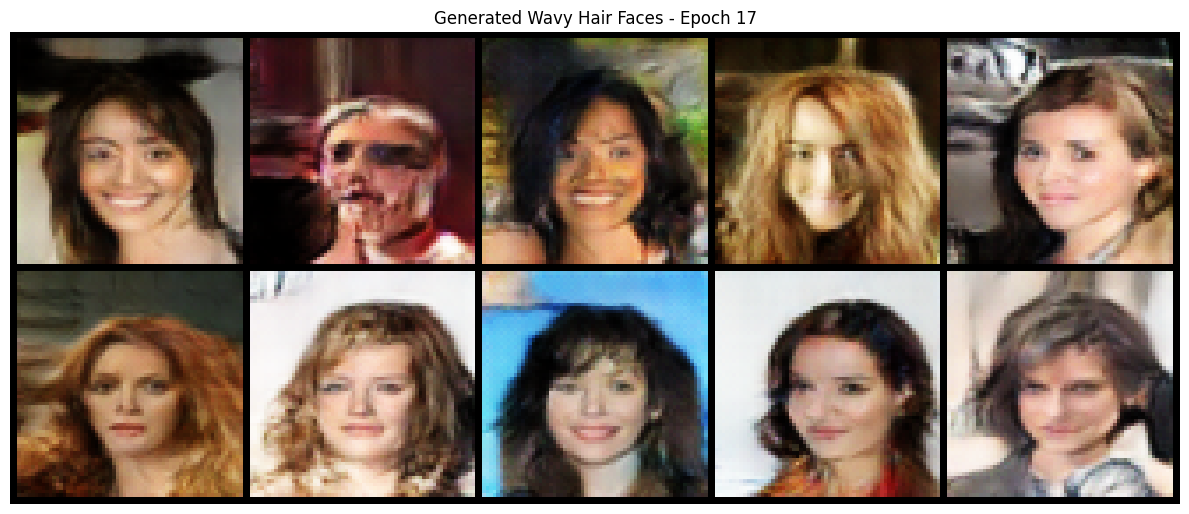

[17/30][0/1012] Loss_D: 0.3144 Loss_G: 3.7113 D(x): 0.8732 D(G(z)): 0.1356 / 0.0404
[17/30][50/1012] Loss_D: 0.5646 Loss_G: 1.1572 D(x): 0.6324 D(G(z)): 0.0375 / 0.3890
[17/30][100/1012] Loss_D: 0.2504 Loss_G: 3.3523 D(x): 0.8343 D(G(z)): 0.0401 / 0.0604
[17/30][150/1012] Loss_D: 0.6079 Loss_G: 4.4078 D(x): 0.7640 D(G(z)): 0.2189 / 0.0229
[17/30][200/1012] Loss_D: 0.4210 Loss_G: 2.7873 D(x): 0.7393 D(G(z)): 0.0642 / 0.1071
[17/30][250/1012] Loss_D: 0.4384 Loss_G: 3.0477 D(x): 0.8175 D(G(z)): 0.1766 / 0.0670
[17/30][300/1012] Loss_D: 2.3834 Loss_G: 0.7191 D(x): 0.1361 D(G(z)): 0.0020 / 0.5415
[17/30][350/1012] Loss_D: 0.6484 Loss_G: 3.9989 D(x): 0.9390 D(G(z)): 0.3746 / 0.0293
[17/30][400/1012] Loss_D: 1.3743 Loss_G: 7.7897 D(x): 0.9638 D(G(z)): 0.6338 / 0.0010
[17/30][450/1012] Loss_D: 0.4840 Loss_G: 3.4098 D(x): 0.9298 D(G(z)): 0.2916 / 0.0451
[17/30][500/1012] Loss_D: 0.5633 Loss_G: 2.0722 D(x): 0.6297 D(G(z)): 0.0141 / 0.2058
[17/30][550/1012] Loss_D: 0.7721 Loss_G: 3.5654 D(x): 0.7

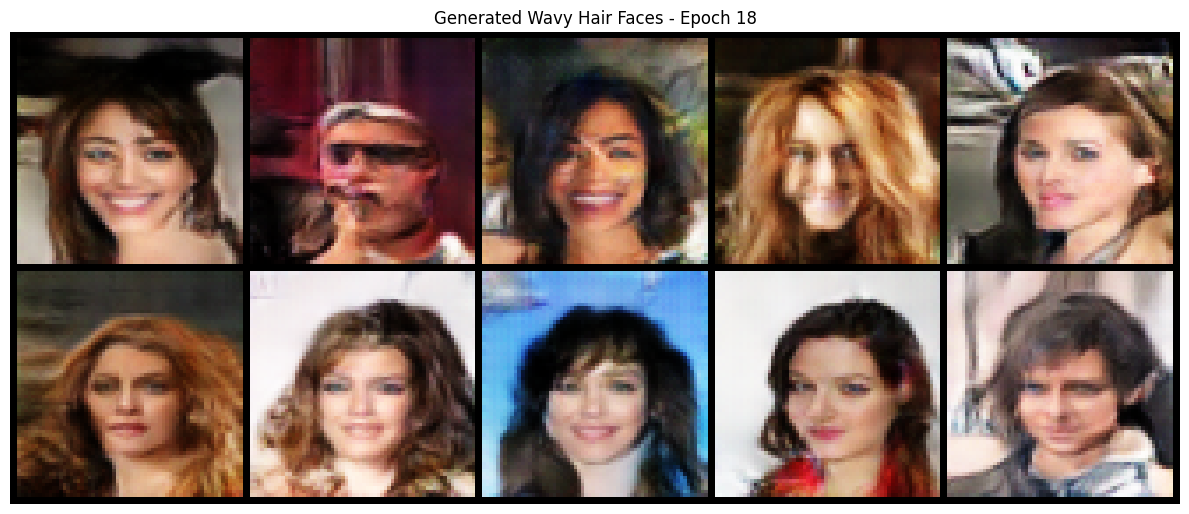

[18/30][0/1012] Loss_D: 0.4584 Loss_G: 2.8281 D(x): 0.7372 D(G(z)): 0.0869 / 0.0953
[18/30][50/1012] Loss_D: 0.2029 Loss_G: 4.2751 D(x): 0.9635 D(G(z)): 0.1410 / 0.0224
[18/30][100/1012] Loss_D: 0.3380 Loss_G: 2.7030 D(x): 0.8148 D(G(z)): 0.0863 / 0.1033
[18/30][150/1012] Loss_D: 0.4017 Loss_G: 4.9836 D(x): 0.9938 D(G(z)): 0.2795 / 0.0101
[18/30][200/1012] Loss_D: 0.3573 Loss_G: 2.6848 D(x): 0.7734 D(G(z)): 0.0667 / 0.1065
[18/30][250/1012] Loss_D: 0.2352 Loss_G: 4.0445 D(x): 0.9385 D(G(z)): 0.1378 / 0.0262
[18/30][300/1012] Loss_D: 0.3738 Loss_G: 2.8266 D(x): 0.7951 D(G(z)): 0.1066 / 0.0929
[18/30][350/1012] Loss_D: 0.4009 Loss_G: 3.4997 D(x): 0.8251 D(G(z)): 0.1525 / 0.0389
[18/30][400/1012] Loss_D: 0.2515 Loss_G: 4.4921 D(x): 0.9187 D(G(z)): 0.1364 / 0.0149
[18/30][450/1012] Loss_D: 0.5008 Loss_G: 2.0922 D(x): 0.7192 D(G(z)): 0.1020 / 0.1733
[18/30][500/1012] Loss_D: 0.3080 Loss_G: 3.2992 D(x): 0.9084 D(G(z)): 0.1775 / 0.0474
[18/30][550/1012] Loss_D: 0.2912 Loss_G: 3.1297 D(x): 0.8

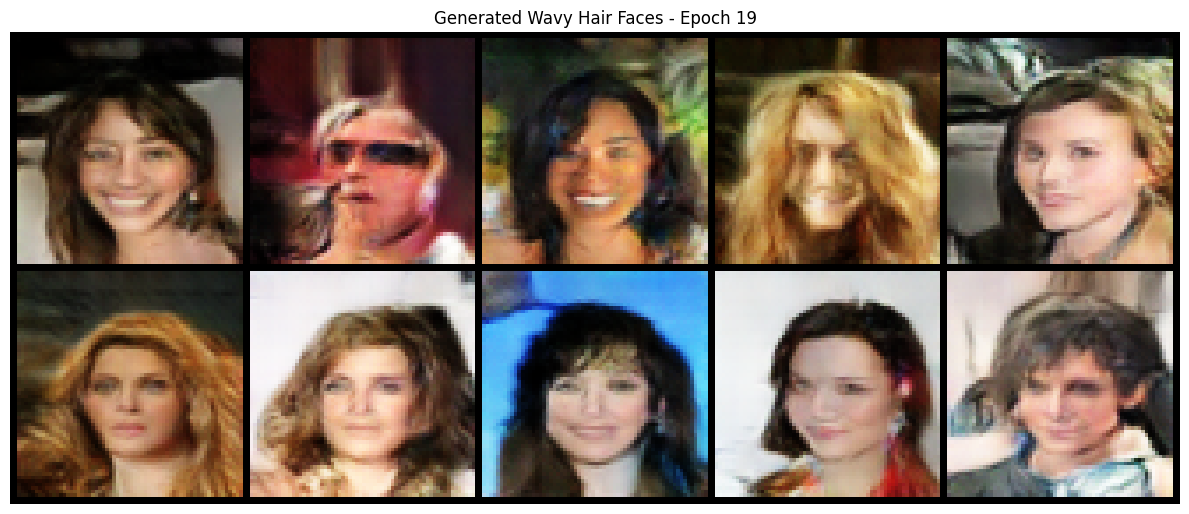

[19/30][0/1012] Loss_D: 0.3352 Loss_G: 3.9757 D(x): 0.8821 D(G(z)): 0.1496 / 0.0277
[19/30][50/1012] Loss_D: 0.1669 Loss_G: 3.5512 D(x): 0.9187 D(G(z)): 0.0707 / 0.0438
[19/30][100/1012] Loss_D: 0.3174 Loss_G: 4.0352 D(x): 0.9555 D(G(z)): 0.2172 / 0.0242
[19/30][150/1012] Loss_D: 1.1215 Loss_G: 1.3241 D(x): 0.4059 D(G(z)): 0.0061 / 0.3770
[19/30][200/1012] Loss_D: 0.1976 Loss_G: 3.1948 D(x): 0.9388 D(G(z)): 0.1061 / 0.0615
[19/30][250/1012] Loss_D: 0.1486 Loss_G: 3.1707 D(x): 0.9241 D(G(z)): 0.0616 / 0.0675
[19/30][300/1012] Loss_D: 0.1861 Loss_G: 3.7639 D(x): 0.9372 D(G(z)): 0.1054 / 0.0318
[19/30][350/1012] Loss_D: 0.5783 Loss_G: 6.8577 D(x): 0.9536 D(G(z)): 0.3225 / 0.0019
[19/30][400/1012] Loss_D: 0.3062 Loss_G: 3.0980 D(x): 0.8439 D(G(z)): 0.0947 / 0.0643
[19/30][450/1012] Loss_D: 0.3491 Loss_G: 5.2567 D(x): 0.9626 D(G(z)): 0.2347 / 0.0075
[19/30][500/1012] Loss_D: 0.9040 Loss_G: 7.2919 D(x): 0.9779 D(G(z)): 0.4735 / 0.0013
[19/30][550/1012] Loss_D: 0.9681 Loss_G: 1.1022 D(x): 0.4

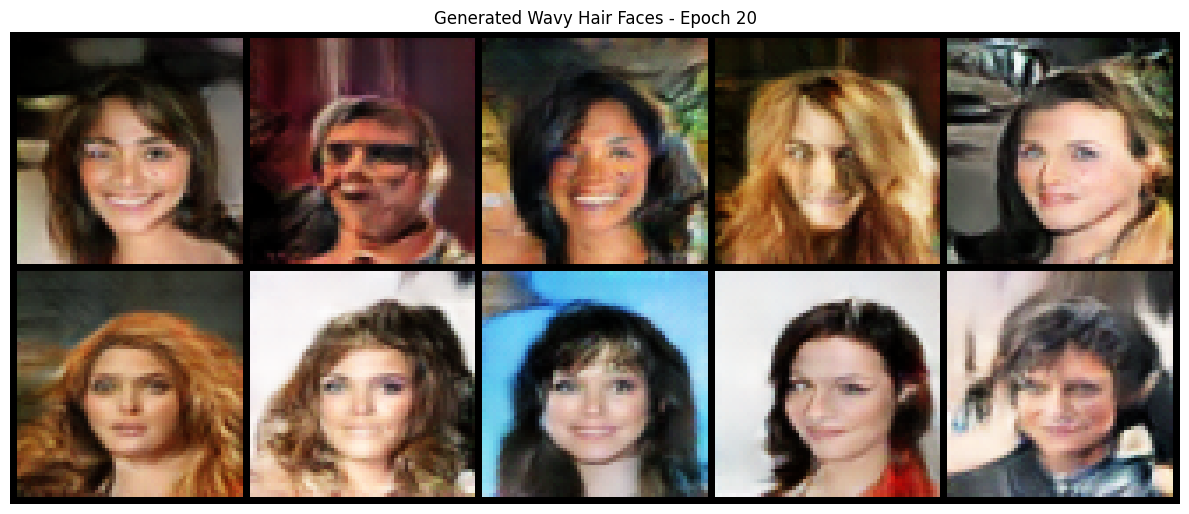

[20/30][0/1012] Loss_D: 0.1493 Loss_G: 4.0571 D(x): 0.9741 D(G(z)): 0.1054 / 0.0278
[20/30][50/1012] Loss_D: 0.4125 Loss_G: 3.3750 D(x): 0.7073 D(G(z)): 0.0093 / 0.0586
[20/30][100/1012] Loss_D: 0.1883 Loss_G: 4.3880 D(x): 0.8990 D(G(z)): 0.0697 / 0.0210
[20/30][150/1012] Loss_D: 0.1908 Loss_G: 3.3518 D(x): 0.8743 D(G(z)): 0.0348 / 0.0507
[20/30][200/1012] Loss_D: 0.5745 Loss_G: 1.9642 D(x): 0.6266 D(G(z)): 0.0229 / 0.1998
[20/30][250/1012] Loss_D: 0.2107 Loss_G: 3.8295 D(x): 0.8800 D(G(z)): 0.0641 / 0.0373
[20/30][300/1012] Loss_D: 0.3880 Loss_G: 4.9461 D(x): 0.9431 D(G(z)): 0.2340 / 0.0104
[20/30][350/1012] Loss_D: 0.1670 Loss_G: 3.7358 D(x): 0.8951 D(G(z)): 0.0460 / 0.0359
[20/30][400/1012] Loss_D: 0.2143 Loss_G: 3.8707 D(x): 0.9057 D(G(z)): 0.0948 / 0.0303
[20/30][450/1012] Loss_D: 0.2917 Loss_G: 3.4534 D(x): 0.8885 D(G(z)): 0.1310 / 0.0482
[20/30][500/1012] Loss_D: 0.3913 Loss_G: 2.2385 D(x): 0.7507 D(G(z)): 0.0567 / 0.1644
[20/30][550/1012] Loss_D: 0.2895 Loss_G: 2.8374 D(x): 0.8

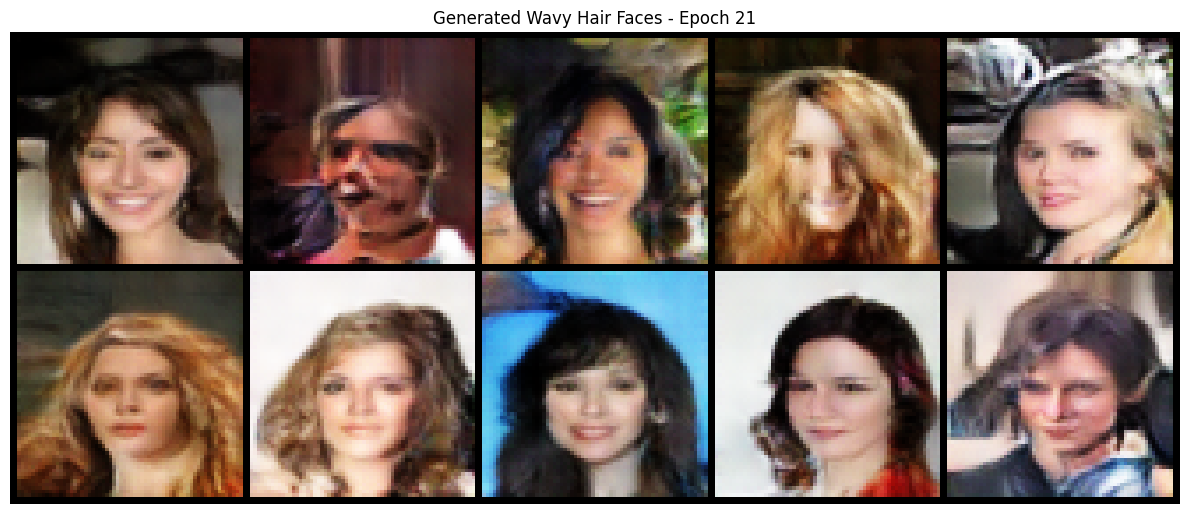

[21/30][0/1012] Loss_D: 0.5375 Loss_G: 4.8058 D(x): 0.9859 D(G(z)): 0.3256 / 0.0131
[21/30][50/1012] Loss_D: 0.3218 Loss_G: 4.6704 D(x): 0.9541 D(G(z)): 0.2046 / 0.0145
[21/30][100/1012] Loss_D: 0.1939 Loss_G: 4.1637 D(x): 0.9818 D(G(z)): 0.1456 / 0.0225
[21/30][150/1012] Loss_D: 0.3052 Loss_G: 5.5669 D(x): 0.9657 D(G(z)): 0.1851 / 0.0060
[21/30][200/1012] Loss_D: 0.2840 Loss_G: 3.3527 D(x): 0.7926 D(G(z)): 0.0229 / 0.0663
[21/30][250/1012] Loss_D: 0.1856 Loss_G: 3.6067 D(x): 0.9200 D(G(z)): 0.0882 / 0.0413
[21/30][300/1012] Loss_D: 0.5531 Loss_G: 4.2348 D(x): 0.9262 D(G(z)): 0.2986 / 0.0337
[21/30][350/1012] Loss_D: 0.2965 Loss_G: 4.2661 D(x): 0.9139 D(G(z)): 0.1673 / 0.0213
[21/30][400/1012] Loss_D: 1.7305 Loss_G: 1.0001 D(x): 0.2687 D(G(z)): 0.0010 / 0.4946
[21/30][450/1012] Loss_D: 0.2111 Loss_G: 3.4961 D(x): 0.8898 D(G(z)): 0.0760 / 0.0532
[21/30][500/1012] Loss_D: 0.2854 Loss_G: 3.4801 D(x): 0.8343 D(G(z)): 0.0724 / 0.0496
[21/30][550/1012] Loss_D: 0.3344 Loss_G: 2.6866 D(x): 0.7

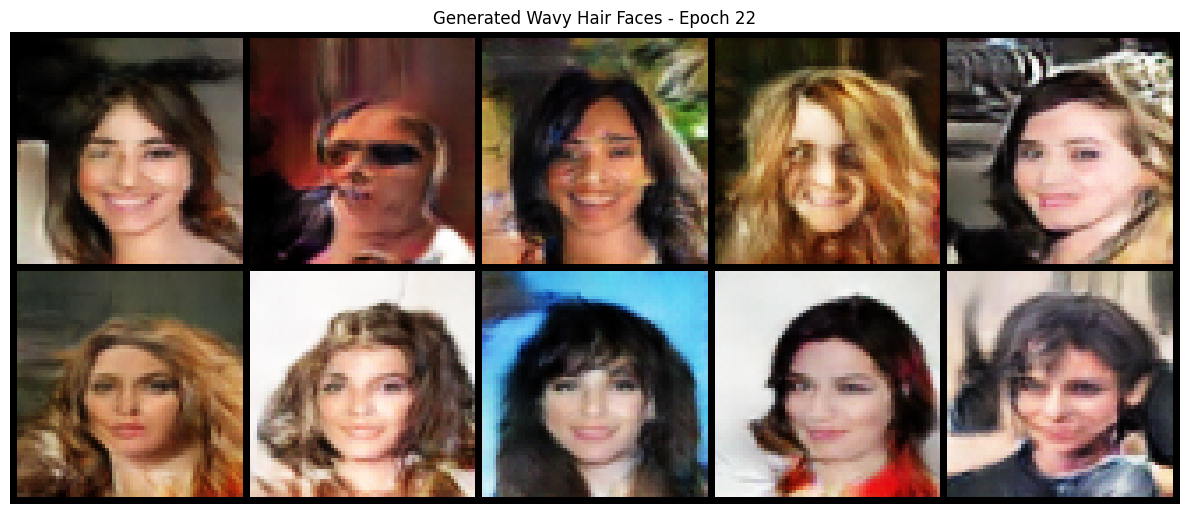

[22/30][0/1012] Loss_D: 0.1509 Loss_G: 3.9834 D(x): 0.9538 D(G(z)): 0.0917 / 0.0301
[22/30][50/1012] Loss_D: 0.1956 Loss_G: 3.6165 D(x): 0.9235 D(G(z)): 0.0987 / 0.0417
[22/30][100/1012] Loss_D: 0.1325 Loss_G: 4.5289 D(x): 0.9640 D(G(z)): 0.0822 / 0.0191
[22/30][150/1012] Loss_D: 0.2032 Loss_G: 5.2083 D(x): 0.9707 D(G(z)): 0.1441 / 0.0098
[22/30][200/1012] Loss_D: 0.1118 Loss_G: 4.3835 D(x): 0.9383 D(G(z)): 0.0394 / 0.0269
[22/30][250/1012] Loss_D: 0.3156 Loss_G: 5.1721 D(x): 0.9848 D(G(z)): 0.2227 / 0.0084
[22/30][300/1012] Loss_D: 0.1374 Loss_G: 4.1148 D(x): 0.9834 D(G(z)): 0.0976 / 0.0257
[22/30][350/1012] Loss_D: 0.0805 Loss_G: 3.9403 D(x): 0.9576 D(G(z)): 0.0350 / 0.0322
[22/30][400/1012] Loss_D: 0.2747 Loss_G: 4.3982 D(x): 0.9001 D(G(z)): 0.1180 / 0.0210
[22/30][450/1012] Loss_D: 0.1529 Loss_G: 4.0068 D(x): 0.9651 D(G(z)): 0.1010 / 0.0276
[22/30][500/1012] Loss_D: 1.9550 Loss_G: 7.9801 D(x): 0.9879 D(G(z)): 0.7523 / 0.0010
[22/30][550/1012] Loss_D: 0.2702 Loss_G: 5.5196 D(x): 0.9

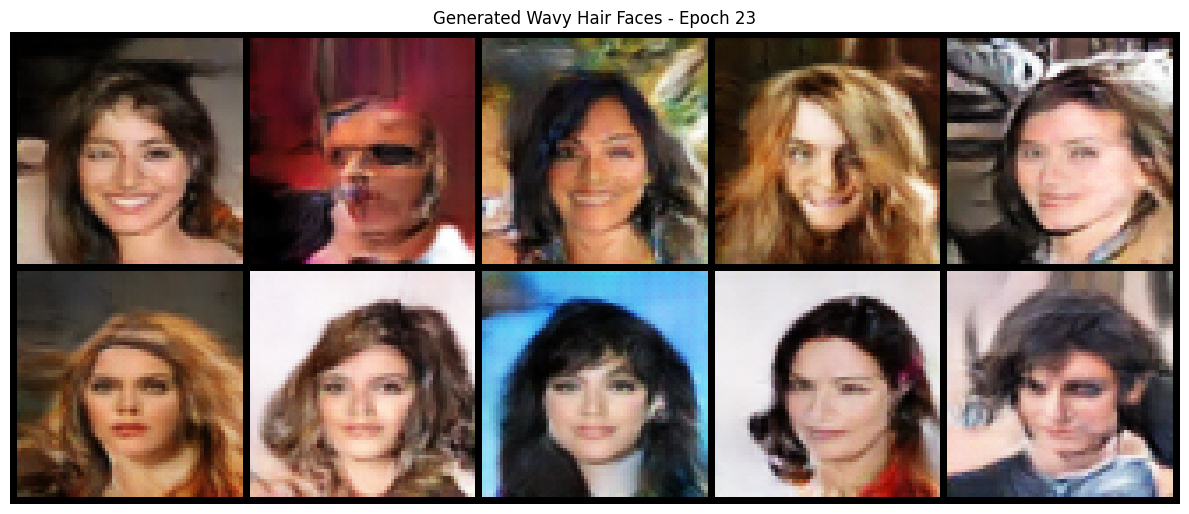

[23/30][0/1012] Loss_D: 0.3393 Loss_G: 1.5279 D(x): 0.7539 D(G(z)): 0.0195 / 0.2872
[23/30][50/1012] Loss_D: 0.4388 Loss_G: 4.2319 D(x): 0.9615 D(G(z)): 0.2732 / 0.0219
[23/30][100/1012] Loss_D: 0.2305 Loss_G: 4.3235 D(x): 0.8972 D(G(z)): 0.0847 / 0.0281
[23/30][150/1012] Loss_D: 0.1098 Loss_G: 5.3499 D(x): 0.9824 D(G(z)): 0.0796 / 0.0096
[23/30][200/1012] Loss_D: 0.2456 Loss_G: 4.4064 D(x): 0.9615 D(G(z)): 0.1698 / 0.0174
[23/30][250/1012] Loss_D: 0.1920 Loss_G: 3.7941 D(x): 0.8684 D(G(z)): 0.0337 / 0.0354
[23/30][300/1012] Loss_D: 0.2257 Loss_G: 3.8300 D(x): 0.9309 D(G(z)): 0.1265 / 0.0307
[23/30][350/1012] Loss_D: 0.3162 Loss_G: 3.8612 D(x): 0.8748 D(G(z)): 0.1329 / 0.0332
[23/30][400/1012] Loss_D: 0.1318 Loss_G: 4.4879 D(x): 0.9557 D(G(z)): 0.0762 / 0.0170
[23/30][450/1012] Loss_D: 0.2023 Loss_G: 3.9181 D(x): 0.9834 D(G(z)): 0.1467 / 0.0296
[23/30][500/1012] Loss_D: 0.2086 Loss_G: 4.2279 D(x): 0.9728 D(G(z)): 0.1496 / 0.0223
[23/30][550/1012] Loss_D: 0.1816 Loss_G: 4.1172 D(x): 0.9

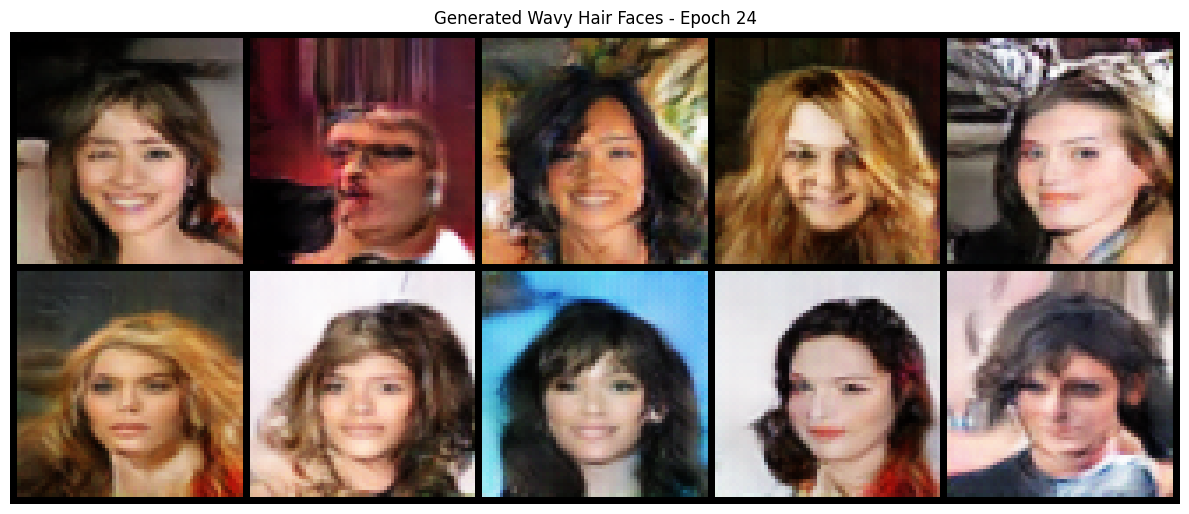

[24/30][0/1012] Loss_D: 0.3972 Loss_G: 5.1847 D(x): 0.9407 D(G(z)): 0.2307 / 0.0096
[24/30][50/1012] Loss_D: 0.1820 Loss_G: 3.7424 D(x): 0.9319 D(G(z)): 0.0926 / 0.0378
[24/30][100/1012] Loss_D: 0.1894 Loss_G: 4.0173 D(x): 0.8836 D(G(z)): 0.0474 / 0.0346
[24/30][150/1012] Loss_D: 0.1552 Loss_G: 4.4625 D(x): 0.9431 D(G(z)): 0.0843 / 0.0188
[24/30][200/1012] Loss_D: 0.8404 Loss_G: 1.8547 D(x): 0.6632 D(G(z)): 0.2204 / 0.2107
[24/30][250/1012] Loss_D: 0.5251 Loss_G: 5.5590 D(x): 0.9931 D(G(z)): 0.3297 / 0.0066
[24/30][300/1012] Loss_D: 0.1586 Loss_G: 3.5438 D(x): 0.9409 D(G(z)): 0.0835 / 0.0450
[24/30][350/1012] Loss_D: 0.1668 Loss_G: 3.8646 D(x): 0.8800 D(G(z)): 0.0229 / 0.0434
[24/30][400/1012] Loss_D: 2.0839 Loss_G: 2.3581 D(x): 0.2129 D(G(z)): 0.0024 / 0.2012
[24/30][450/1012] Loss_D: 0.1611 Loss_G: 3.5430 D(x): 0.9048 D(G(z)): 0.0453 / 0.0485
[24/30][500/1012] Loss_D: 0.6190 Loss_G: 7.1337 D(x): 0.9829 D(G(z)): 0.3855 / 0.0014
[24/30][550/1012] Loss_D: 0.2782 Loss_G: 3.1322 D(x): 0.8

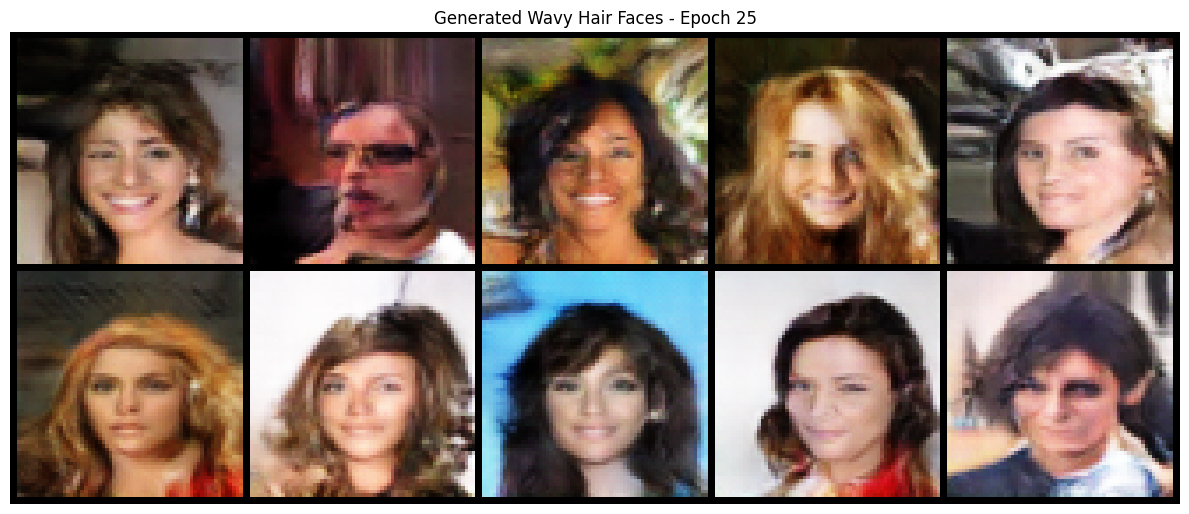

[25/30][0/1012] Loss_D: 0.4354 Loss_G: 5.3256 D(x): 0.9962 D(G(z)): 0.3124 / 0.0067
[25/30][50/1012] Loss_D: 0.1283 Loss_G: 4.4455 D(x): 0.9128 D(G(z)): 0.0174 / 0.0198
[25/30][100/1012] Loss_D: 0.1391 Loss_G: 4.4889 D(x): 0.9691 D(G(z)): 0.0955 / 0.0157
[25/30][150/1012] Loss_D: 0.3241 Loss_G: 2.9338 D(x): 0.8161 D(G(z)): 0.0811 / 0.0920
[25/30][200/1012] Loss_D: 0.1883 Loss_G: 4.7087 D(x): 0.9496 D(G(z)): 0.1030 / 0.0162
[25/30][250/1012] Loss_D: 0.0874 Loss_G: 3.7441 D(x): 0.9538 D(G(z)): 0.0362 / 0.0363
[25/30][300/1012] Loss_D: 0.2140 Loss_G: 3.3526 D(x): 0.8560 D(G(z)): 0.0318 / 0.0550
[25/30][350/1012] Loss_D: 0.2326 Loss_G: 3.4328 D(x): 0.8659 D(G(z)): 0.0591 / 0.0486
[25/30][400/1012] Loss_D: 0.1256 Loss_G: 4.1288 D(x): 0.9171 D(G(z)): 0.0344 / 0.0297
[25/30][450/1012] Loss_D: 0.2108 Loss_G: 4.9178 D(x): 0.9766 D(G(z)): 0.1525 / 0.0112
[25/30][500/1012] Loss_D: 0.2093 Loss_G: 3.5923 D(x): 0.8956 D(G(z)): 0.0813 / 0.0405
[25/30][550/1012] Loss_D: 0.1078 Loss_G: 4.2451 D(x): 0.9

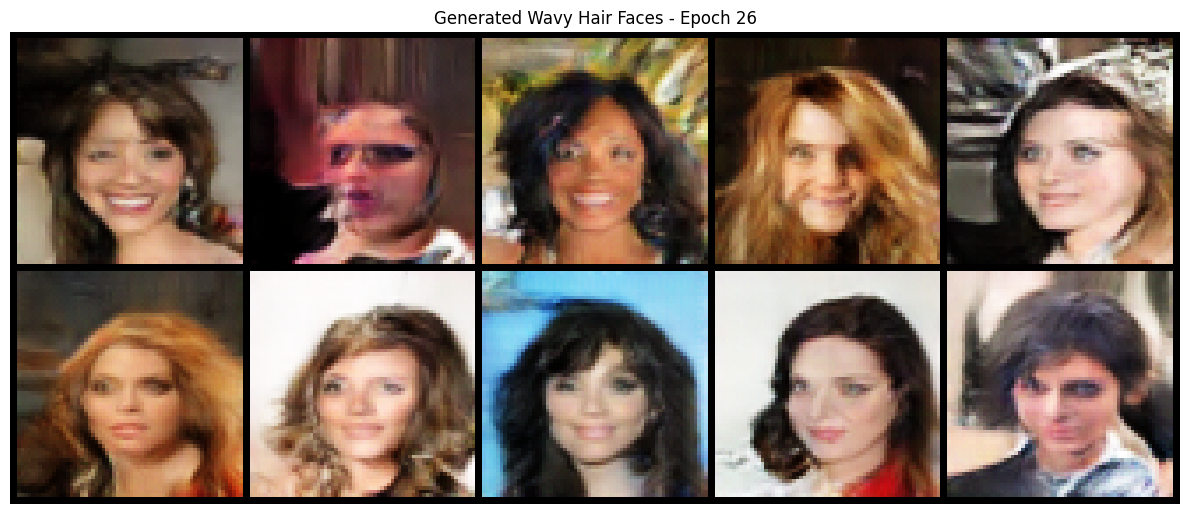

[26/30][0/1012] Loss_D: 0.1249 Loss_G: 5.0129 D(x): 0.9860 D(G(z)): 0.0967 / 0.0119
[26/30][50/1012] Loss_D: 0.0637 Loss_G: 4.8710 D(x): 0.9746 D(G(z)): 0.0356 / 0.0154
[26/30][100/1012] Loss_D: 0.1208 Loss_G: 3.8502 D(x): 0.9247 D(G(z)): 0.0346 / 0.0404
[26/30][150/1012] Loss_D: 0.5341 Loss_G: 2.0300 D(x): 0.6445 D(G(z)): 0.0077 / 0.2134
[26/30][200/1012] Loss_D: 0.0661 Loss_G: 3.9602 D(x): 0.9685 D(G(z)): 0.0316 / 0.0314
[26/30][250/1012] Loss_D: 0.1876 Loss_G: 3.4511 D(x): 0.8635 D(G(z)): 0.0271 / 0.0580
[26/30][300/1012] Loss_D: 2.5602 Loss_G: 0.1164 D(x): 0.2024 D(G(z)): 0.0069 / 0.9165
[26/30][350/1012] Loss_D: 0.1861 Loss_G: 4.9130 D(x): 0.9801 D(G(z)): 0.1393 / 0.0128
[26/30][400/1012] Loss_D: 0.3183 Loss_G: 2.8082 D(x): 0.7978 D(G(z)): 0.0469 / 0.1115
[26/30][450/1012] Loss_D: 0.1687 Loss_G: 3.2486 D(x): 0.9170 D(G(z)): 0.0662 / 0.0636
[26/30][500/1012] Loss_D: 0.2151 Loss_G: 3.5446 D(x): 0.8809 D(G(z)): 0.0651 / 0.0503
[26/30][550/1012] Loss_D: 0.1933 Loss_G: 3.3794 D(x): 0.9

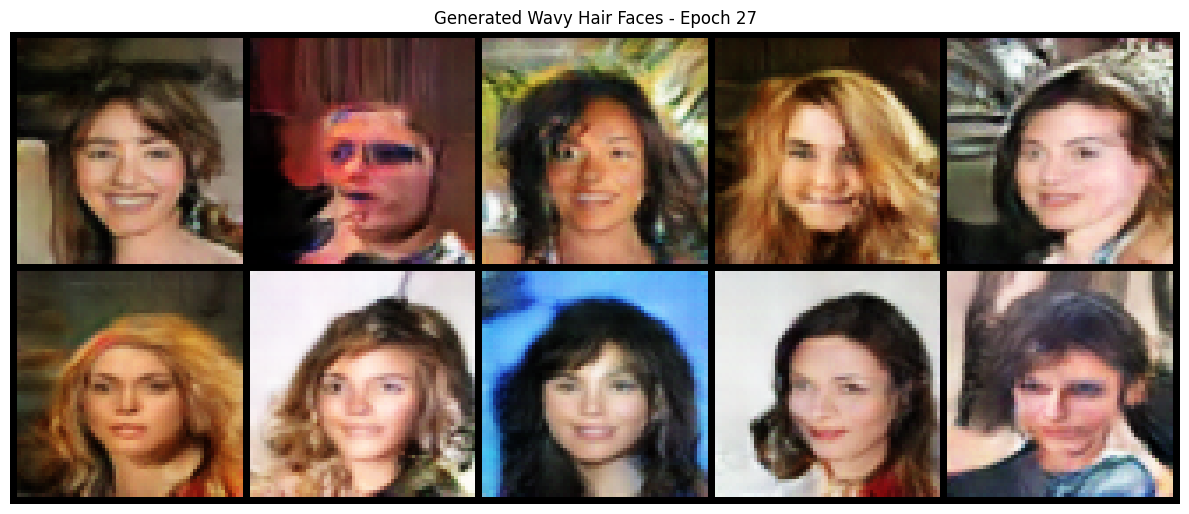

[27/30][0/1012] Loss_D: 0.3018 Loss_G: 5.1991 D(x): 0.9934 D(G(z)): 0.2113 / 0.0081
[27/30][50/1012] Loss_D: 0.3454 Loss_G: 2.9430 D(x): 0.8586 D(G(z)): 0.0992 / 0.0748
[27/30][100/1012] Loss_D: 0.1059 Loss_G: 5.4220 D(x): 0.9530 D(G(z)): 0.0513 / 0.0086
[27/30][150/1012] Loss_D: 0.5162 Loss_G: 1.6884 D(x): 0.6645 D(G(z)): 0.0111 / 0.2751
[27/30][200/1012] Loss_D: 0.1418 Loss_G: 3.8035 D(x): 0.9169 D(G(z)): 0.0468 / 0.0375
[27/30][250/1012] Loss_D: 0.1077 Loss_G: 4.1413 D(x): 0.9551 D(G(z)): 0.0569 / 0.0257
[27/30][300/1012] Loss_D: 3.2562 Loss_G: 10.2066 D(x): 0.9976 D(G(z)): 0.9021 / 0.0003
[27/30][350/1012] Loss_D: 0.3295 Loss_G: 5.2081 D(x): 0.9253 D(G(z)): 0.1665 / 0.0121
[27/30][400/1012] Loss_D: 0.2404 Loss_G: 3.5357 D(x): 0.8797 D(G(z)): 0.0840 / 0.0437
[27/30][450/1012] Loss_D: 0.5634 Loss_G: 7.4704 D(x): 0.9974 D(G(z)): 0.3825 / 0.0009
[27/30][500/1012] Loss_D: 0.5146 Loss_G: 5.5689 D(x): 0.9952 D(G(z)): 0.3257 / 0.0072
[27/30][550/1012] Loss_D: 0.1889 Loss_G: 3.7881 D(x): 0.

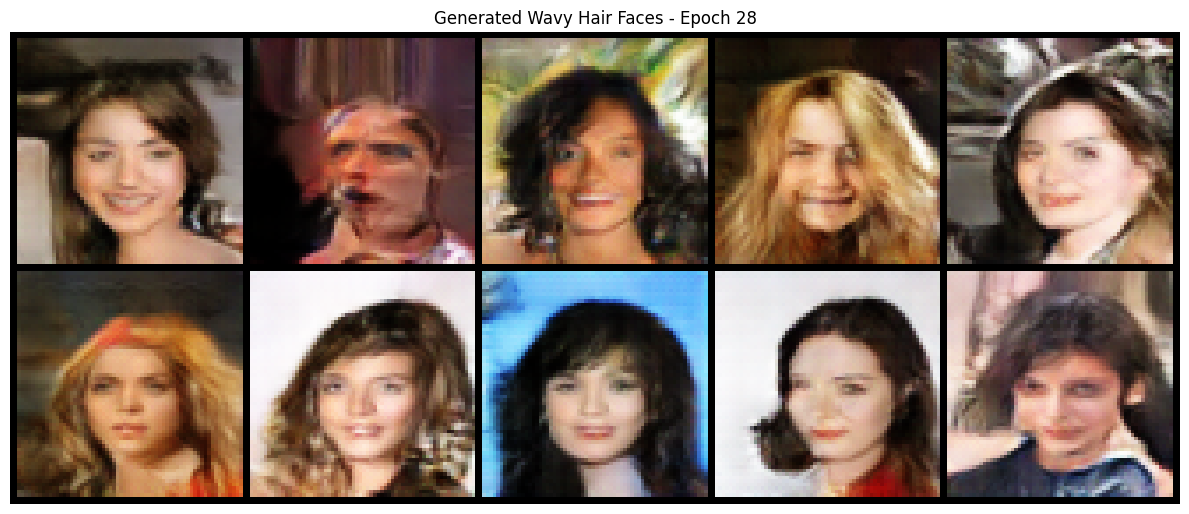

[28/30][0/1012] Loss_D: 0.3880 Loss_G: 3.5031 D(x): 0.7908 D(G(z)): 0.0872 / 0.0593
[28/30][50/1012] Loss_D: 0.1841 Loss_G: 3.8852 D(x): 0.9163 D(G(z)): 0.0769 / 0.0388
[28/30][100/1012] Loss_D: 0.1662 Loss_G: 4.4672 D(x): 0.9399 D(G(z)): 0.0914 / 0.0190
[28/30][150/1012] Loss_D: 0.1908 Loss_G: 3.3028 D(x): 0.8782 D(G(z)): 0.0426 / 0.0655
[28/30][200/1012] Loss_D: 0.0859 Loss_G: 5.3424 D(x): 0.9505 D(G(z)): 0.0308 / 0.0098
[28/30][250/1012] Loss_D: 0.3400 Loss_G: 2.1000 D(x): 0.7674 D(G(z)): 0.0387 / 0.2051
[28/30][300/1012] Loss_D: 0.1743 Loss_G: 6.0225 D(x): 0.9856 D(G(z)): 0.1100 / 0.0047
[28/30][350/1012] Loss_D: 0.1199 Loss_G: 4.3303 D(x): 0.9825 D(G(z)): 0.0870 / 0.0227
[28/30][400/1012] Loss_D: 1.6799 Loss_G: 1.4012 D(x): 0.2650 D(G(z)): 0.0049 / 0.4174
[28/30][450/1012] Loss_D: 0.2077 Loss_G: 5.0521 D(x): 0.9318 D(G(z)): 0.1070 / 0.0110
[28/30][500/1012] Loss_D: 0.1419 Loss_G: 4.4696 D(x): 0.9928 D(G(z)): 0.1170 / 0.0175
[28/30][550/1012] Loss_D: 0.1888 Loss_G: 3.3800 D(x): 0.8

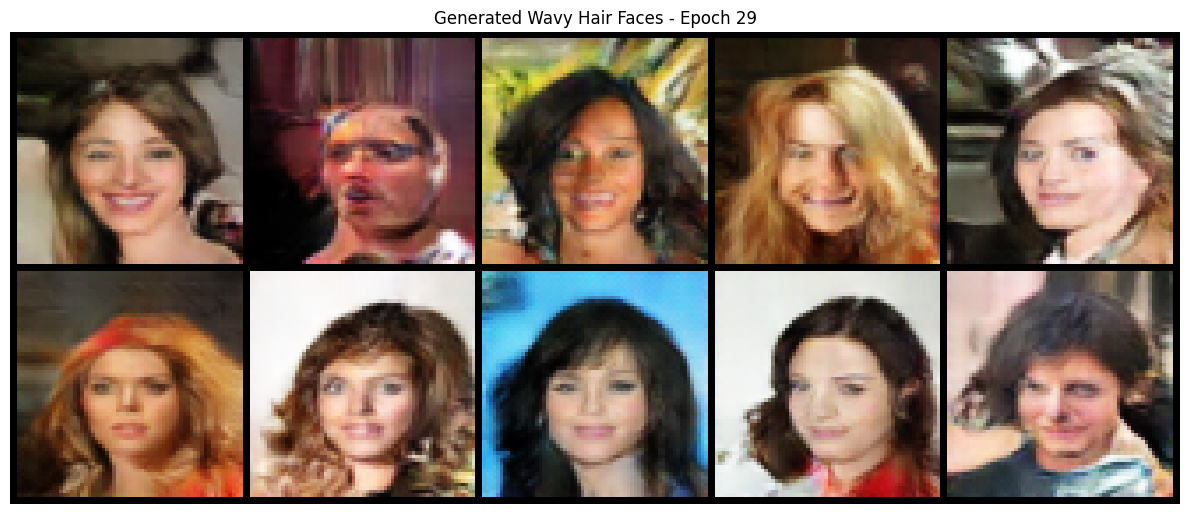

[29/30][0/1012] Loss_D: 0.7903 Loss_G: 0.2393 D(x): 0.6252 D(G(z)): 0.1381 / 0.8212
[29/30][50/1012] Loss_D: 0.1404 Loss_G: 4.1080 D(x): 0.9505 D(G(z)): 0.0765 / 0.0254
[29/30][100/1012] Loss_D: 0.1266 Loss_G: 3.9400 D(x): 0.9327 D(G(z)): 0.0499 / 0.0369
[29/30][150/1012] Loss_D: 0.1423 Loss_G: 3.1480 D(x): 0.9078 D(G(z)): 0.0371 / 0.0688
[29/30][200/1012] Loss_D: 0.1587 Loss_G: 4.6083 D(x): 0.9876 D(G(z)): 0.1245 / 0.0160
[29/30][250/1012] Loss_D: 0.1144 Loss_G: 4.0646 D(x): 0.9310 D(G(z)): 0.0366 / 0.0398
[29/30][300/1012] Loss_D: 0.1356 Loss_G: 3.6660 D(x): 0.9071 D(G(z)): 0.0296 / 0.0517
[29/30][350/1012] Loss_D: 0.1120 Loss_G: 3.9920 D(x): 0.9366 D(G(z)): 0.0414 / 0.0308
[29/30][400/1012] Loss_D: 0.3360 Loss_G: 7.6315 D(x): 0.9852 D(G(z)): 0.2429 / 0.0009
[29/30][450/1012] Loss_D: 0.1731 Loss_G: 5.7211 D(x): 0.9377 D(G(z)): 0.0895 / 0.0083
[29/30][500/1012] Loss_D: 0.1372 Loss_G: 4.3482 D(x): 0.9387 D(G(z)): 0.0620 / 0.0247
[29/30][550/1012] Loss_D: 0.1329 Loss_G: 5.2281 D(x): 0.9

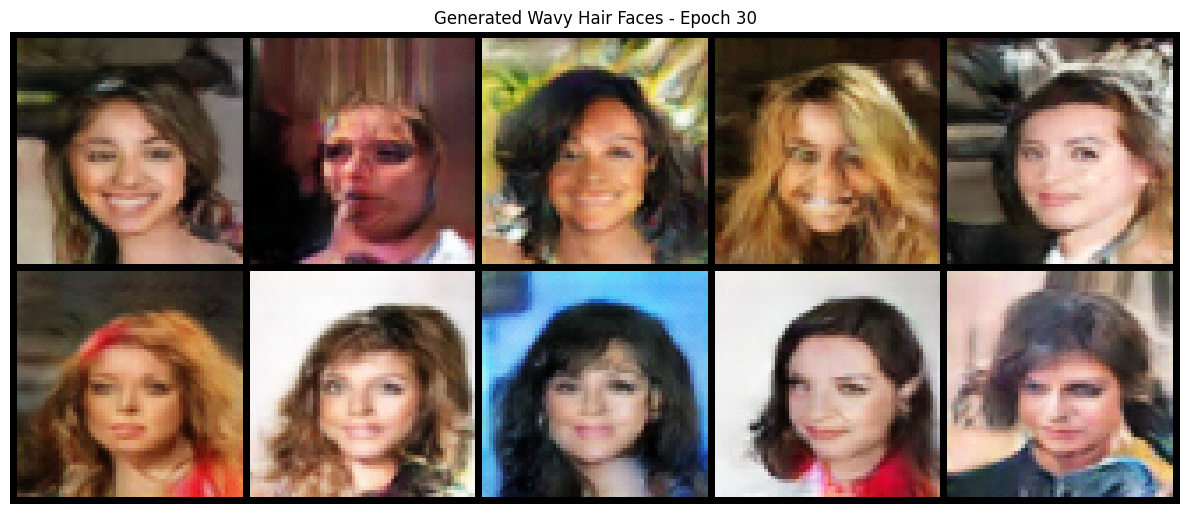

Training completed!


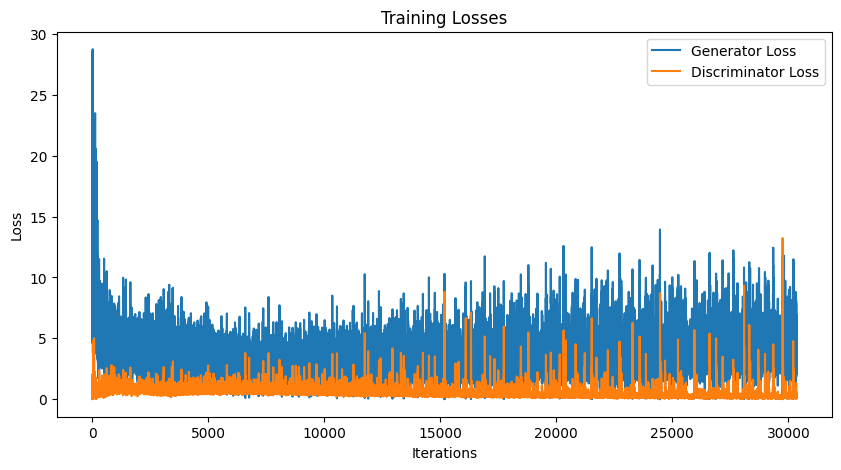

Generating final batch of wavy hair faces...


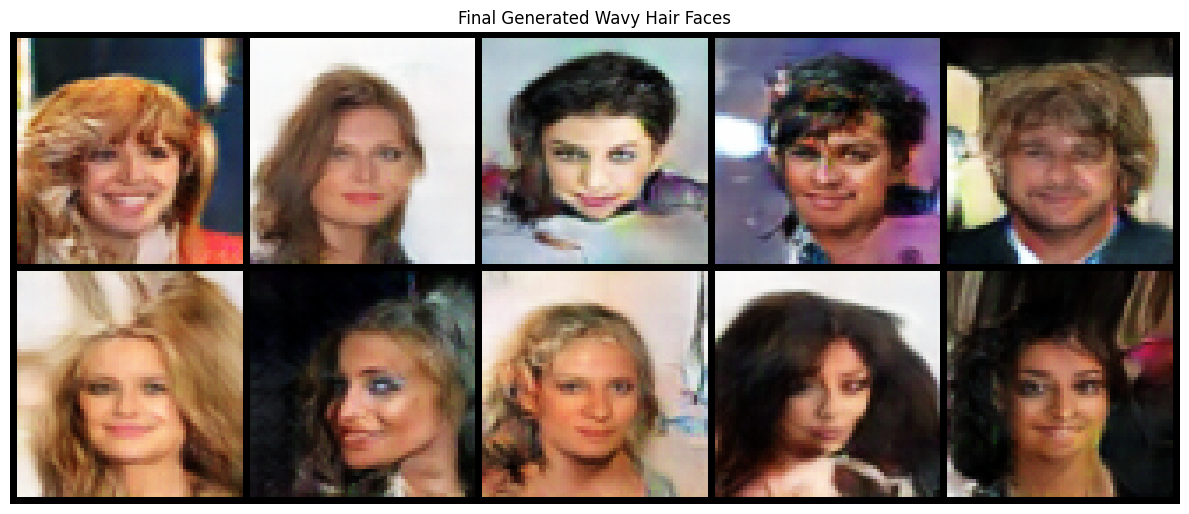

All done! Check the saved images for your generated wavy hair faces.


In [34]:
# Training Loop
G_losses = []
D_losses = []

print("Starting Training...")
for epoch in range(NUM_EPOCHS):
    for i, (data, conditions) in enumerate(dataloader):
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()

        # Train with real data
        real_data = data.to(device)
        real_conditions = conditions.to(device)
        batch_size = real_data.size(0)

        label = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
        output = netD(real_data, real_conditions)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Train with fake data
        noise = torch.randn(batch_size, NZ, 1, 1, device=device)
        fake_conditions = torch.ones(batch_size, 1, device=device)  # All wavy hair
        fake_data = netG(noise, fake_conditions)

        label.fill_(0.0)
        output = netD(fake_data.detach(), fake_conditions)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        label.fill_(1.0)
        output = netD(fake_data, fake_conditions)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Print statistics
        if i % 50 == 0:
            print(f'[{epoch}/{NUM_EPOCHS}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        # Save losses for plotting
        G_losses.append(errG.item())
        D_losses.append(errD.item())

    # Generate and display images every epoch
    with torch.no_grad():
        fake = netG(fixed_noise, fixed_condition)

        # Create 2x5 grid
        plt.figure(figsize=(12, 6))
        grid = vutils.make_grid(fake.cpu(), nrow=5, normalize=True, padding=2)
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.title(f'Generated Wavy Hair Faces - Epoch {epoch+1}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        # Save the image
        vutils.save_image(fake.cpu(), f'generated_wavy_hair_epoch_{epoch+1}.png',
                         nrow=5, normalize=True, padding=2)

print("Training completed!")

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

# Generate final batch of images
print("Generating final batch of wavy hair faces...")
with torch.no_grad():
    final_noise = torch.randn(10, NZ, 1, 1, device=device)
    final_condition = torch.ones(10, 1, device=device)
    final_fake = netG(final_noise, final_condition)

    plt.figure(figsize=(12, 6))
    grid = vutils.make_grid(final_fake.cpu(), nrow=5, normalize=True, padding=2)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title('Final Generated Wavy Hair Faces')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Save final images
    vutils.save_image(final_fake.cpu(), 'final_wavy_hair_faces.png',
                     nrow=5, normalize=True, padding=2)

print("All done! Check the saved images for your generated wavy hair faces.")